# PhD: EStreams variables exploration


Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

This notebook is used to explore the correlations between signatures but now using only catchment groups with from 20-40 nested catchments within. The idea is to use a more concise number of catchemnts to understand better the behaviour of the catchments. 


# Import modules

In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import geopandas as gpd
import networkx as nx
from shapely.geometry import Polygon, Point
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings

from utils.functions import compute_correlation_score, find_unique_nested_catchments, find_directly_connected_catchments
from utils.plots import plot_histograms_by_group, plot_histograms_by_group_two_subsets, plot_watershed_groups_from_dict


# Configurations

In [2]:
# Only editable variables:
# Relative path to your local directory
PATH = ".."

# Set the directory:
os.chdir(PATH)

warnings.simplefilter(action='ignore', category=Warning)

# Import data

### - Network information

In [3]:
network_estreams = pd.read_csv('../estreams_part_b/data/EStreams/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,9497,0.0,0.0,9497.0,0.0,B,[CH000197],1,16,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,[CH000221],1,1,[AT000002]
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,13513,0.0,0.0,13513.0,0.0,B,[CH000215],1,2,"[AT000002, AT000003, CH000221]"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,8765,0.0,0.0,8765.0,0.0,B,[CH000227],1,1,[AT000004]
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10957,0.0,0.0,10957.0,0.0,B,[CH000214],1,3,"[AT000005, CH000214]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1988,1,[UAGR0017]
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1989,1,[UAGR0018]
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1990,1,[UAGR0019]


### - Filtered attributes

In [107]:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../estreams_part_b/data/exploration/estreams_attributes_filtered_moselle_3.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 
estreams_attributes

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,0.127,23.0,10.0,10.0,6.62,542.33,33.844,23.025,29.307,22.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,0.040,4.0,4.0,3.0,1.46,12.91,36.927,0.000,0.204,18.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.023,1.0,1.0,1.0,0.89,8.27,34.486,0.000,0.084,10.0
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,0.058,7.0,6.0,5.0,2.67,23.90,32.887,0.000,0.399,40.0
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.016,0.0,0.0,0.0,0.00,0.00,27.201,0.000,0.000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,0.000,0.0,0.0,95.0,29.74,124.55,8.705,163.532,152.585,4.0
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,0.000,0.0,0.0,1.0,1.43,16.43,3.805,0.000,0.000,3.0
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,0.000,0.0,0.0,1.0,0.31,1.54,4.928,0.000,0.000,1.0


In [108]:
nested_catchments = pd.DataFrame(estreams_attributes['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

nested_catchments

,nested_catchments
basin_id,
AT000001,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000003,"[AT000002, AT000003, CH000221]"
AT000005,"[AT000005, CH000214]"
AT000007,"[AT000002, AT000003, AT000004, AT000005, AT000..."
AT000008,[AT000008]
...,...
UAGR0016,[UAGR0016]
UAGR0017,[UAGR0017]
UAGR0019,[UAGR0019]


### - Geology high resolution FF (32 clases)

In [109]:
estreams_geology_ff_31_classes_moselle = pd.read_csv("../estreams_part_b/data/new_attributes/estreams_geology_moselle_ff_all_classes_attributes.csv", encoding='utf-8')

estreams_geology_ff_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl'],
    
    "lower": ['lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "impermeable": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    estreams_geology_ff_31_classes_moselle[f'area_perm_{permeability_class}'] = estreams_geology_ff_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
estreams_geology_ff_31_classes_moselle = estreams_geology_ff_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_lower", "area_perm_impermeable"]]

# Rename the columns
estreams_geology_ff_31_classes_moselle.columns = ["perm_high_ff2", "perm_medium_ff2", "perm_lower_ff2", "perm_impermeable_ff2"]

# Display the updated DataFrame
estreams_geology_ff_31_classes_moselle

estreams_geology_ff_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
estreams_geology_ff_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_ff2", "perm_medium_ff2", "perm_lower_ff2", "perm_impermeable_ff2"]] = estreams_geology_ff_31_classes_moselle[["perm_high_ff2", "perm_medium_ff2", "perm_lower_ff2", "perm_impermeable_ff2"]]
estreams_attributes

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_ff2,perm_medium_ff2,perm_lower_ff2,perm_impermeable_ff2
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,6.62,542.33,33.844,23.025,29.307,22.0,NaN,NaN,NaN,NaN
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,1.46,12.91,36.927,0.000,0.204,18.0,NaN,NaN,NaN,NaN
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.89,8.27,34.486,0.000,0.084,10.0,NaN,NaN,NaN,NaN
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,2.67,23.90,32.887,0.000,0.399,40.0,NaN,NaN,NaN,NaN
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.00,0.00,27.201,0.000,0.000,8.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,29.74,124.55,8.705,163.532,152.585,4.0,NaN,NaN,NaN,NaN
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,1.43,16.43,3.805,0.000,0.000,3.0,NaN,NaN,NaN,NaN
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,0.31,1.54,4.928,0.000,0.000,1.0,NaN,NaN,NaN,NaN


### - Catchment boundaries

In [7]:
catchment_boundaries = gpd.read_file('../estreams_part_b/data/EStreams/shapefiles/estreams_catchments.shp')
catchment_boundaries

,basin_id,gauge_id,country,area_offic,area_estre,area_flag,area_rel,start_date,end_date,gauge_flag,upstream,group,geometry
0,AT000001,200014,AT,4647.9,4668.379,0,-0.440608,1996-01-01,2021-12-31,B,16,1,"POLYGON Z ((9.69406 46.54322 0.00000, 9.69570 ..."
1,AT000002,200048,AT,102.0,102.287,0,-0.281373,1958-10-01,2021-12-31,B,1,1,"POLYGON Z ((10.13650 47.02949 0.00000, 10.1349..."
2,AT000003,231662,AT,535.2,536.299,0,-0.205344,1985-01-02,2021-12-31,B,2,1,"POLYGON Z ((10.11095 46.89437 0.00000, 10.1122..."
3,AT000004,200592,AT,66.6,66.286,0,0.471471,1998-01-02,2021-12-31,B,1,1,"POLYGON Z ((10.14189 47.09706 0.00000, 10.1404..."
4,AT000005,200097,AT,72.2,72.448,0,-0.343490,1990-01-01,2019-12-31,B,3,1,"POLYGON Z ((9.67851 47.06249 0.00000, 9.67888 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17125,UAGR0017,6682300,UA,321.0,325.370,0,-1.361371,1978-01-01,1987-12-31,B,1,1988,"POLYGON Z ((33.96791 44.63291 0.00000, 33.9679..."
17126,UAGR0018,6682500,UA,49.7,47.594,0,4.237425,1978-01-01,1987-12-31,B,1,1989,"POLYGON Z ((34.19958 44.58291 0.00000, 34.2029..."
17127,UAGR0019,6683010,UA,261.0,244.731,1,6.233333,1978-01-01,1987-12-31,B,1,1990,"POLYGON Z ((34.19624 44.88375 0.00000, 34.1962..."
17128,UAGR0020,6683200,UA,760.0,731.073,0,3.806184,1978-01-01,1987-12-31,B,1,1991,"POLYGON Z ((35.78708 47.28708 0.00000, 35.7870..."


# Investigation

### Multiple Linear Regression 

In [8]:
def compute_correlation(target_column, data_subset):
    """
    Compute the R2 coefficient for a given target column and data subset.

    Parameters:
        target_column (str): Name of the target column.
        data_subset (DataFrame): DataFrame containing the subset of data.

    Returns:
        DataFrame: DataFrame with R2 coefficient as a row.
    """
    # Extract target variable and features
    y = data_subset[target_column]
    X = data_subset.iloc[:, 14:-1]

    # Check if there are enough samples to compute R2 coefficient
    if len(X) <= 1:
        return pd.DataFrame({'Feature': ['R2_coefficient'], 'Coefficient': [np.nan]})
    
    # Define preprocessing steps
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Define column transformer to apply preprocessing only to numeric features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])

    # Define the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('correlation', LinearRegression())])

    # Fit the pipeline
    pipeline.fit(X, y)
    
    # Compute R2 coefficient
    y_pred = pipeline.predict(X)
    r2_coefficient = r2_score(y, y_pred)

    # Create a DataFrame with R2 coefficient as a row
    r2_df = pd.DataFrame({'Feature': ['R2_coefficient'], 'Coefficient': [r2_coefficient]})
    
    return r2_df


### - Histograms considering different catchment groups

In [9]:
# Histograms for different catchments groups:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histograms_by_group(df, col_to_classify, num_cols=3):
    """
    Plot histograms for each class within each variable in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        col_to_classify (str): Name of the column containing the classes.
        num_cols (int): Number of columns in each row of subplots. Default is 3.
    """
    # Get unique classes
    classes = df[col_to_classify].unique()
    classes = classes.astype(int)
    num_classes = len(classes)
    
    # Determine number of rows and columns for subplots
    num_rows = (df.shape[1] - 1) // num_cols + 1

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*3))

    # Flatten the axes array
    axes = axes.flatten()

    # Plot histograms for each variable
    for i, (col, ax) in enumerate(zip(df.columns, axes)):
        if col != col_to_classify:
            for cls in classes:
                ax.hist(df[df[col_to_classify].astype(int) == cls][col], bins=10, alpha=0.5, label=cls)
            ax.set_title(col)
            ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()


### - Function to find the groups with no repeatetive catchments

In [10]:
def find_max_unique_rows(df):
    """
    Return rows with the maximum number of values not repeateded in the other rows.

    Parameters:
        df (DataFrame): The DataFrame containing rows with lists of values.

    Returns:
        list: A list of indices of rows with the maximum number of unique values.
    """
    max_unique_rows = []  # List to store the indices of rows with maximum number of values
    col_name = df.columns[0]  # Get the name of the column containing the lists of values
    
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        #current_row_values = row[col_name].split(', ')  # Convert string to list of values
        current_row_values = row[col_name]

        max_unique_count = len(current_row_values)  # Initialize the maximum count to the number of values in the current row
        
        # Loop through other rows to find potential overlapping rows
        for other_index, other_row in df.iterrows():
            if index != other_index:  # Skip the current row
                #other_row_values = other_row[col_name].split(', ')  # Convert string to list of values
                other_row_values = other_row[col_name] 

                # Find the intersection of values between the current row and the other row
                intersection = set(current_row_values).intersection(other_row_values)
                if intersection:  # If there's any intersection
                    other_row_count = len(other_row_values)
                    if other_row_count > max_unique_count:  # If the other row has more values than the current maximum
                        max_unique_count = other_row_count  # Update the maximum count
        
        # Add the index of the current row to the list if it has the maximum count of values
        if len(current_row_values) == max_unique_count:
            max_unique_rows.append(index)
    
    return max_unique_rows

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_watershed_groups_from_dict(estreams_attributes_used, title_plot="Plot title", figsize=(8, 6), ax=None, 
                                    add_legend=False, size_symbol=2, limits_europe=True):
    """
    Plot watershed groups on a map using GeoPandas.

    Parameters:
        estreams_attributes_used (dict): A dictionary containing watershed groups dataframes.
        title_plot (str): Title of the plot.
        figsize (tuple): Figure size in inches (width, height).
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If None, a new figure and axes will be created.
        add_legend (bool): Whether to add a legend to the plot.
        size_symbol (int): Size of the symbols in the plot.
        limits_europe (bool): Whether to set the plot limits to Europe.

    Returns:
        None
    """
    
    # Load the world shapefile dataset provided by GeoPandas
    gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Set font properties using rcParams
    mpl.rcParams['font.family'] = 'arial'  # Change the font family
    mpl.rcParams['font.size'] = 8            # Change the font size
    mpl.rcParams['font.weight'] = 'normal'   # Change font weight
    mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Clear the subplot
    ax.clear()

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.1)

    # Calculate the bounds of the data if limits_europe is False
    if not limits_europe:
        all_lons = []
        all_lats = []
        for data in estreams_attributes_used.values():
            all_lons.extend(data['lon'])
            all_lats.extend(data['lat'])
        
        if all_lons and all_lats:
            min_lon, max_lon = min(all_lons), max(all_lons)
            min_lat, max_lat = min(all_lats), max(all_lats)
            margin = 0.05  # Add some margin to the bounds
            ax.set_xlim(min_lon - margin, max_lon + margin)
            ax.set_ylim(min_lat - margin, max_lat + margin)

    else:
        ax.set_xlim(-24, 45)
        ax.set_ylim(35, 70)

    # Define markers for each watershed group
    markers = ['o', 's', '^', 'D', 'P']  # You can extend this list if needed

    # Plot the gauges for each desired watershed group
    colors = plt.cm.tab10(np.linspace(0, 1, len(estreams_attributes_used.keys())))  # Get distinct colors
    i = 0
    for catchment, data in estreams_attributes_used.items():
        marker = markers[i % len(markers)]  # Choose marker cyclically
        color = colors[i]  # Choose color from the colormap
        ax.scatter(data['lon'], data['lat'], color=color, edgecolor='black',
                    linewidth=0.01, marker=marker, s=size_symbol, label=catchment)
        i += 1

    ax.set_aspect('equal')  # Adjust aspect ratio as needed
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axis_off()  # Turn off both x-axis and y-axis

    # Set title for the plot
    ax.set_title(title_plot)
    # Add legend (if needed)
    if add_legend:
        ax.legend()

    # Adjust layout
    plt.tight_layout()


# Pre-processing
* Selecting the catchments:

        - Here we select only the catchments upstream


        Not only the nmber of gauges, but the area covered matters. Below 30T- 
        Even the ones in Portugal highly modified with dams, we can clearly see the improvment (3 main ones)
        There is one where there is an icnrease in the mean and others, but decrease in BFI. 
        

In [ ]:
GB000271,FR000408,FR003812,FR003919,FR004221*,FR001604*,(FR004239), ES000664,ES000325*, ES000422,ITTO0398,FI000557,PL000536*
    PL000533, HR000280*,HR000280*, HR000274,HR000103,PL001058,PL000936,PL000532,PL000536**,PL000794,DEBW0186,
    DEBY0833*,DEBU1953,FR002291,FR002209, FR002679,ES000194,ES000196,ES001334,ES000705,PT000239,
PT000006, PT000125,GB000271, GB000472, GB000306,FR003819,BEVL0155,NL000016,BEWA0027,PL000256,ITVE0408,ITPI0170*, ITPI0220,
ITGR0001,ITLC0146,ES000558

In [203]:
list_cats_list = ["GB000271","FR000408","FR003812","FR003919","FR004239", "ES000325", "ES000422","ITTO0398","FI000557","PL000536", 
                  "PL000533", "HR000274","HR000103","PL001058","PL000936","PL000536","PL000794","DEBY0833","DEBU1953",
                  "FR002291","FR002209", "FR002679","ES000194","ES000196","ES001334","ES000705","PT000239",

"PT000006", "PT000125","GB000271", "GB000472", "GB000306","FR003819","BEVL0155","NL000016","BEWA0027","PL000256","ITVE0408","ITPI0220",
"ITGR0001","ITLC0146","ES000558", 

"FR001071","FR000374","FR003870","FR003984","FR003978","FR003954", "HR000047","HR000127","HR000174","CZ000464", "AT000393",
"AT000389","FR002464", "FR003986", "FR000325","ES001171","ITPI0183","DK000165","FR004651","FR002758", "FI000137","ES000796"]



list_cats_list = ["ES000801", "ES000665","ES001243", "ES000196", "ES000116", "ES000194", "ES001080", "ES000316","ES000397","ES000339","ES000331", 
                  "GB000472", "GB000271", "GB000153","ITTO0361","ITVE0408","ITLC0146", "ITPI0183", "SE000102", "FI000668", "FI000585", "FI000557", 
                  "FI000226", "FI000137", "PL000936","PL000905", "PL000868", "PL000794","HR000048","HUGR0037", "AT000393", "PL000253", 
                  "PL000349", "PL000015","CZ000097","DEST1711", "DEBY0711","DEBY0724", "DEBY0697", "DEBU1953", "NL000008","CH000026", "FR002679", 
                  "FR004615", "NL000016", "BEVL0155", "FR000408", "FR000373", "FR000345", "FR001071", "FR003922", "FR003986", "FR002118", "FR001952",
                  "FR002029", "FR001604", "FR004221", "ES000738","ES001171", "ES001010", "PL001056", "PL000536", "HR000278", "CZ000236","DEST1707", 
                  "DEBE0155","FR002758","FR002462","FR001394", "FR000867", "FR004308", "DEBU1959"] 


In [204]:
corr_max_group_dfs_dict = {}
corr_max_geology_diff = pd.DataFrame()
corr_max_geology_diff_abs = pd.DataFrame()
corr_max_geology_diff_above_05 = pd.DataFrame()

corr_low_geology_df = pd.DataFrame()
corr_med_geology_df = pd.DataFrame()
corr_low_geology_df_25 = pd.DataFrame()
corr_med_geology_df_25 = pd.DataFrame()
corr_med_climate_df = pd.DataFrame()
corr_med_soils_df = pd.DataFrame()
corr_med_topography_df = pd.DataFrame()
corr_med_landuse_df = pd.DataFrame()

lens_df = pd.DataFrame()

for list_cats in list_cats_list:
    nested_cats_df = nested_catchments.loc[[list_cats], :]

    # Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 
    # Filter only the catchemnts using the function stated before:
    nested_cats_filtered = find_max_unique_rows(nested_cats_df)

    # Here we filter the catchemnts for the list (again, after we apply our function):
    nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]


    # Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
    estreams_attributes_dfs = {}
    for catchment in nested_cats_filtered:
        # Retrieve the nested list of catchments for the current catchment
        nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
        
        # Filter values to include only those that exist in the index of estreams_attributes
        nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
        
        # Filter the estreams_attributes DataFrame based on the filtered nested_clip
        cat_clip = estreams_attributes.loc[nested_clip, :]
        
        # Store the resulting DataFrame in the dictionary
        estreams_attributes_dfs[catchment] = cat_clip



    # Here we can save the length of each watershed (number of nested catchemnts)
    catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
    for catchment, data in estreams_attributes_dfs.items():
        catchment_lens.loc[catchment, "len"] = len(data)


    # Now we can filter it properly:
    nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]
    #print(nested_cats_filtered_abovevalue)


    # # Here we filter the catchemnts for the list (again, after we apply our function):
    nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

    # Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
    estreams_attributes_dfs = {}

    for catchment in nested_cats_filtered_abovevalue_df.index:
        # Retrieve the nested list of catchments for the current catchment
        nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
        
        # Filter values to include only those that exist in the index of estreams_attributes
        nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
        
        # Filter the estreams_attributes DataFrame based on the filtered nested_clip
        cat_clip = estreams_attributes.loc[nested_clip, :]
        
        # Store the resulting DataFrame in the dictionary
        estreams_attributes_dfs[catchment] = cat_clip


    estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
    estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]


    # Store the correlation matrices for selected catchments in a dictionary:
    # Initialize an empty dictionary to store correlation DataFrames for the selected variables
    correlation_dict = {}

    # Iterate over each variable in the first 14 columns of your data
    for variable in estreams_attributes.columns[29:43]:
        # Initialize an empty DataFrame to store correlations
        correlation_df = pd.DataFrame()

        # Iterate over each watershed group
        for catchment in estreams_attributes_dfs.keys():

            estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
            estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
            estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
        'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
        'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
        'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
        'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
        'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
        'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
        'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

        'perc_imp','perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 
        'perm_impermeable_euro', 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
        "perm_impermeable_ff2", "perm_lower_ff2", "perm_medium_ff2", "perm_high_ff2",
        
        'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
        'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
        'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
        'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
        'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
        'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
        'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
            
            # Calculate correlations between the current variable and other variables
            correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
            
            # Add the correlations to the DataFrame
            correlation_df[catchment] = correlations

        # Add the correlation DataFrame to the dictionary
        correlation_dict[variable] = correlation_df

    # Assuming correlation_dict is a dictionary containing all correlation DataFrames
    # Initialize an empty list to store individual correlation DataFrames
    correlation_list = []

    # Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
    for signature in correlation_dict.keys():
        corr_df = correlation_dict[signature].T
        corr_df['signature'] = signature  # Add a column to identify the signature
        correlation_list.append(corr_df)

    # Concatenate all correlation DataFrames along the rows
    combined_correlation_df = pd.concat(correlation_list)

    # Preserve the order of the signatures by converting to categorical type
    combined_correlation_df['signature'] = pd.Categorical(
        combined_correlation_df['signature'],
        categories=list(correlation_dict.keys()),
        ordered=True
    )

    # Set the signature column as the index
    combined_correlation_df.set_index('signature', inplace=True)

    # Group the variable features to groups
    # Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
    variable_dict = {
        'p_mean': 'climatic',
        'pet_mean': 'climatic',
        'aridity': 'climatic',
        'p_seasonality': 'climatic',
        'frac_snow': 'climatic',
        'hp_freq': 'climatic',
        'hp_dur': 'climatic',
        'hp_time': 'climatic',
        'lp_freq': 'climatic',
        'lp_dur': 'climatic',
        'lp_time': 'climatic',
        'ele_mt_max': 'topography',
        'ele_mt_mean': 'topography',
        'ele_mt_min': 'topography',
        'slp_dg_mean': 'topography',
        'flat_area_fra': 'topography',
        'steep_area_fra': 'topography',
        'elon_ratio': 'topography',
        'strm_dens': 'topography',
        'lit_dom': 'geology',
        'bedrk_dep': 'soil',
        'perc_imp': 'geology_low',
        'perc_low_perm': 'geology_low',
        'perc_medium_perm': 'geology_low',
        'perc_high_perm': 'geology_low',
        'root_dep_mean': 'soil',
        'root_dep_max': 'soil',
        'root_dep_min': 'soil',
        'soil_tawc_mean': 'soil',
        'soil_fra_sand_mean': 'soil',
        'soil_fra_silt_mean': 'soil',
        'soil_fra_clay_mean': 'soil',
        'soil_fra_grav_mean': 'soil',
        'soil_bd_mean': 'soil',
        'soil_oc_mean': 'soil',
        'lai_mean': 'lulc',
        'ndvi_mean': 'lulc',
        'lulc_2006_urban': 'lulc',
        'lulc_2006_NonIrriAgri': 'lulc',
        'lulc_2006_Agric': 'lulc',
        'lulc_2006_forest': 'lulc',
        'lulc_2006_grass': 'lulc',
        'lulc_2006_agriculture': 'lulc',
        'dam_num': 'hydrology',
        'res_num': 'hydrology',
        'lakes_num': 'hydrology',
        'sno_cov_mean': 'climatic',
        'irri_1990': 'hydrology',
        'irri_2005': 'hydrology',
        'perm_high_euro': 'geology_med',
        'perm_medium_euro': 'geology_med',
        'perm_lower_euro': 'geology_med',
        'perm_impermeable_euro': 'geology_med',
        'stations_num_p_mean': 'climatic',
        "perm_mos_ff": 'geology_high', 
        "semiperm_mos_ff": 'geology_high', 
        "imper_mos_ff": 'geology_high',
        'perm_high_ff2': "geology_high", 
        'perm_medium_ff2': "geology_high", 
        'perm_lower_ff2': "geology_high",
        'perm_impermeable_ff2': "geology_high",
        "area_estreams": "topography"
    }


    # Select the variable
    signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
                'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


    # Define the classes (example list, adjust based on your classes)
    classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

    corr_max_group_dfs = pd.DataFrame(columns = signatures)

    for signature in signatures:
        correlation_df = correlation_dict[signature]
        
        # Initialize the dataframe with columns for each class's maximum correlation and feature
        columns = []
        for cls in classes:
            columns.append(f"corr_max_{cls}")
            columns.append(f"corr_max_feature_{cls}")

        corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

        # Populate the dataframe with the maximum correlations for each class
        for catchment in correlation_df.columns:
            max_corr = {cls: 0 for cls in classes}
            max_feature = {cls: None for cls in classes}

            for feature in correlation_df.index:
                cls = variable_dict[feature]
                corr_value = abs(correlation_df.loc[feature, catchment])

                if corr_value > abs(max_corr[cls]):
                    max_corr[cls] = correlation_df.loc[feature, catchment]
                    max_feature[cls] = feature

            for cls in classes:
                corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
                corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

        # Reclassify geological classes using the mapping dictionary for each class's feature
        for cls in classes:
            corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

        corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                        'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                        'corr_max_vegetation', 'corr_max_hydrology']]

        # Sort and add additional columns
        corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
        corr_max_group_df = corr_max_group_df.astype(float)
        corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
        corr_max_group_dfs[signature] = corr_max_group_df
    
    corr_max_group_dfs_dict[list_cats] = corr_max_group_dfs

    # Compute the maximum and then the absolute difference:
    corr_max_group_dfs_abs = corr_max_group_dfs.abs()

    corr_max_geology_diff[list_cats] = ((corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"])/corr_max_group_dfs_abs.T["corr_max_geology_low"])*100
    corr_max_geology_diff_abs[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"]

    corr_low_geology_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_low"]
    corr_med_geology_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"]
    corr_med_climate_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_climatic"]
    corr_med_soils_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_soil"]
    corr_med_topography_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_topography"]
    corr_med_landuse_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_lulc"]

    lens_df[list_cats] = nested_cats_filtered_abovevalue.len.values

    if nested_cats_filtered_abovevalue.len.values.max() >=30:
        corr_low_geology_df_25[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_low"]
        corr_med_geology_df_25[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"]

    if corr_max_group_dfs_abs.T["corr_max_geology_med"].baseflow_index > 0.5 or corr_max_group_dfs_abs.T["corr_max_geology_low"].baseflow_index > 0.5:
    #    # Compute the percentage difference and the absolute difference for the filtered rows
        corr_max_geology_diff_above_05[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"]





In [205]:
dataframe_BFI

,geoogy_global,geology_continental,climate,soils,topography,landuse,max,area,dams,lakes,len
ES000801,0.687922,0.854495,0.789886,0.596007,0.804415,0.683436,0.804415,26470.566,18.0,58.0,34.0
ES000665,0.143943,0.201949,0.601525,0.613951,0.643886,0.405535,0.643886,32359.392,43.0,42.0,43.0
ES001243,0.566669,0.647460,0.607001,0.686662,0.393601,0.447211,0.686662,33576.944,58.0,46.0,94.0
ES000196,0.160147,0.506889,0.153240,0.457152,0.292403,0.230063,0.457152,15578.353,12.0,9.0,37.0
ES000194,0.128278,0.572327,0.748084,0.427310,0.697862,0.458077,0.748084,14406.755,14.0,17.0,33.0
ES001080,0.610800,0.212546,0.802173,0.535189,0.681117,0.726062,0.802173,15650.545,32.0,32.0,39.0
ES000316,0.542879,0.206789,0.479856,0.431828,0.279395,0.307993,0.479856,25155.699,25.0,30.0,76.0
ES000339,0.284110,0.359208,0.369394,0.267001,0.469774,0.213195,0.469774,12929.504,31.0,31.0,37.0
GB000271,0.330321,0.457553,0.316714,0.590515,0.574471,0.307028,0.590515,9937.208,12.0,111.0,40.0
ITTO0361,0.155194,0.502203,0.652067,0.200383,0.388470,0.227304,0.652067,8900.247,13.0,15.0,31.0


In [206]:
dataframe_BFI = pd.DataFrame()
dataframe_BFI["geoogy_global"] = corr_low_geology_df.T["baseflow_index"]
dataframe_BFI["geology_continental"] = corr_med_geology_df.T["baseflow_index"]
dataframe_BFI["climate"] = corr_med_climate_df.T["baseflow_index"]
dataframe_BFI["soils"] = corr_med_soils_df.T["baseflow_index"]
dataframe_BFI["topography"] = corr_med_topography_df.T["baseflow_index"]
dataframe_BFI["landuse"] = corr_med_landuse_df.T["baseflow_index"]
dataframe_BFI["max"] = dataframe_BFI[["climate", "soils", "topography", "landuse"]].T.max()
dataframe_BFI["area"] = estreams_attributes.loc[list_cats_list, :].area_estreams
dataframe_BFI["dams"] = estreams_attributes.loc[list_cats_list, :].res_num
dataframe_BFI["lakes"] = estreams_attributes.loc[list_cats_list, :].lakes_num
dataframe_BFI["len"] = lens_df.T

dataframe_BFI = dataframe_BFI[dataframe_BFI.len > 30]

dataframe_FDC = pd.DataFrame()
dataframe_FDC["geoogy_global"] = corr_low_geology_df.T["q_95"]
dataframe_FDC["geology_continental"] = corr_med_geology_df.T["q_95"]
dataframe_FDC["climate"] = corr_med_climate_df.T["q_95"]
dataframe_FDC["soils"] = corr_med_soils_df.T["q_95"]
dataframe_FDC["topography"] = corr_med_topography_df.T["q_95"]
dataframe_FDC["landuse"] = corr_med_landuse_df.T["q_95"]
dataframe_FDC["max"] = dataframe_FDC[["climate", "soils", "topography", "landuse"]].T.max()
dataframe_FDC["area"] = estreams_attributes.loc[list_cats_list, :].area_estreams
dataframe_FDC["dams"] = estreams_attributes.loc[list_cats_list, :].res_num
dataframe_FDC["lakes"] = estreams_attributes.loc[list_cats_list, :].lakes_num
dataframe_FDC["len"] = lens_df.T

dataframe_FDC = dataframe_FDC[dataframe_FDC.len > 30]


In [207]:
dataframe_BFI.index

Index(['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000271', 'ITTO0361', 'ITVE0408', 'ITPI0183',
       'FI000557', 'FI000226', 'PL000936', 'PL000794', 'HR000048', 'HUGR0037',
       'AT000393', 'PL000253', 'PL000349', 'PL000015', 'CZ000097', 'DEST1711',
       'DEBY0711', 'DEBY0724', 'DEBY0697', 'DEBU1953', 'NL000008', 'CH000026',
       'FR002679', 'FR004615', 'NL000016', 'BEVL0155', 'FR000408', 'FR000373',
       'FR000345', 'FR001071', 'FR003922', 'FR003986', 'FR002118', 'FR001952',
       'FR002029', 'FR001604', 'FR004221', 'ES001171', 'PL000536', 'HR000278',
       'CZ000236', 'DEST1707', 'DEBE0155', 'FR002758', 'FR002462', 'FR001394',
       'FR000867', 'FR004308', 'DEBU1959'],
      dtype='object')

In [208]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'helvetica'  # Change the font family
mpl.rcParams['font.size'] = 7         # Change the font size
mpl.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

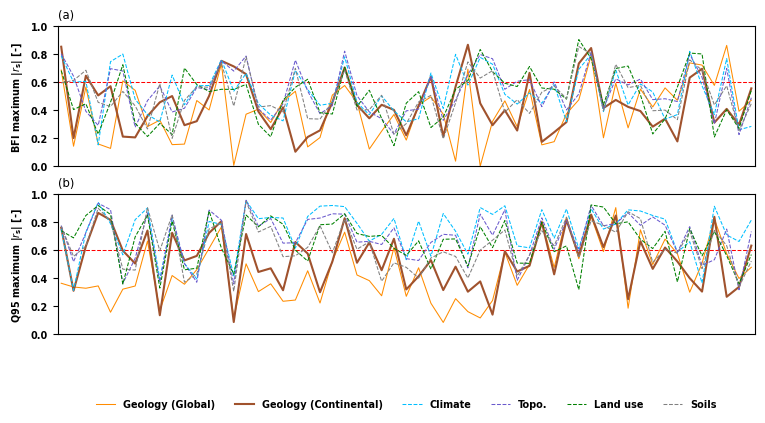

In [209]:
fig, axes = plt.subplots(2, 1, figsize=(9, 4), sharex=True, sharey=True)


# Add a straight horizontal line at y=0.7
axes[0].axhline(y=0.6, color='red', linestyle='--', linewidth=0.75)

axes[0].plot(dataframe_BFI.index, dataframe_BFI['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['geology_continental'], label='Geology (Continental)', color='sienna')
axes[0].plot(dataframe_BFI.index, dataframe_BFI['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
#axes[0].plot(dataframe_BFI.index, dataframe_BFI['max'], label='Other attributes', color='lightgray', linestyle='--', linewidth=0.75)

# Rotate x-axis labels
#axes[0].xticks(rotation=90)
axes[0].set_xticks([])


# Customize legend
#axes[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.38), ncol=7)
axes[0].set_title("(a)", loc="left")

# Set y-axis limits
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.3, 56.3)
axes[0].set_ylabel(r'BFI maximum |$r_{\mathregular{s}}$| [-]')

# Add a straight horizontal line at y=0.7
axes[1].axhline(y=0.6, color='red', linestyle='--', linewidth=0.75)

axes[1].plot(dataframe_FDC.index, dataframe_FDC['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['geology_continental'], label='Geology (Continental)', color='sienna')
axes[1].plot(dataframe_FDC.index, dataframe_FDC['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
#axes[1].plot(dataframe_BFI.index, dataframe_BFI['max'], label='Other attributes', color='lightgray', linestyle='--', linewidth=0.75)

# Get current x-tick labels
#axes[1] = plt.gca()  # Get the current axis
xticks = axes[1].get_xticklabels()

# Change the last x-tick label color to red
if len(xticks) > 0:  # Check if there are any x-ticks
    xticks[-1].set_color('darkred')

# Apply the modified labels back to the plot
axes[1].set_xticklabels(xticks, rotation=90)

# Customize legend
axes[1].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=7)
axes[1].set_title("(b)", loc="left")

# Set y-axis limits
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.3, 56.3)
axes[1].set_ylabel(r'Q95 maximum |$r_{\mathregular{s}}$| [-]')


axes[1].grid(False)
plt.savefig(r'results\figs\fig_lineplot_b_q95_all.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

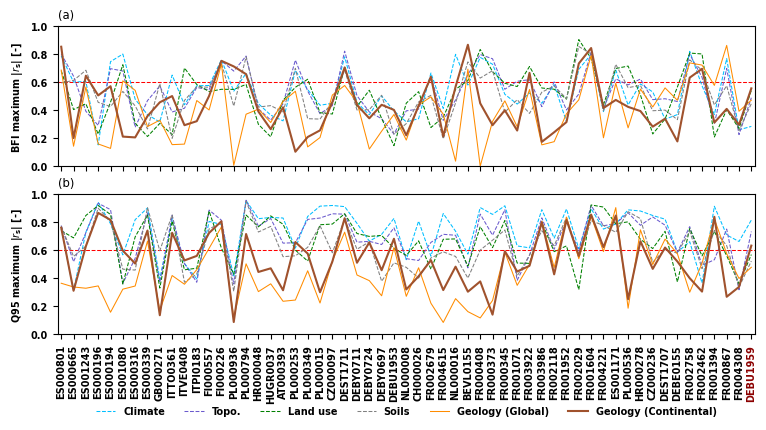

In [210]:
import matplotlib.pyplot as plt

# Create subplots with shared x-axis and y-axis
fig, axes = plt.subplots(2, 1, figsize=(9, 4), sharex=True, sharey=True)

# First subplot (axes[0])
axes[0].axhline(y=0.6, color='red', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes[0].plot(dataframe_BFI.index, dataframe_BFI['geology_continental'], label='Geology (Continental)', color='sienna')

# Customize the legend
axes[0].set_title("(a)", loc="left")
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.3, 56.3)
axes[0].set_ylabel(r'BFI maximum |$r_{\mathregular{s}}$| [-]')

# Second subplot (axes[1])
axes[1].axhline(y=0.6, color='red', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes[1].plot(dataframe_FDC.index, dataframe_FDC['geology_continental'], label='Geology (Continental)', color='sienna')

# Rotate x-tick labels for the second subplot and set the last x-tick color to red
axes[1].tick_params(axis='x', rotation=90)
xticks = axes[1].get_xticklabels()

# Change the color of the last x-tick
if len(xticks) > 0:
    xticks[-1].set_color('darkred')

# Apply modified x-tick labels back to the axis
axes[1].set_xticklabels(xticks)

# Customize the legend
axes[1].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.45), ncol=7)
axes[1].set_title("(b)", loc="left")
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.3, 56.3)
axes[1].set_ylabel(r'Q95 maximum |$r_{\mathregular{s}}$| [-]')

# Disable grid for second subplot
axes[1].grid(False)

# Save and show the plot
plt.savefig(r'results\figs\fig_lineplot.png', dpi=300, bbox_inches='tight')
plt.show()


In [211]:
len(dataframe_BFI_sorted)

57

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

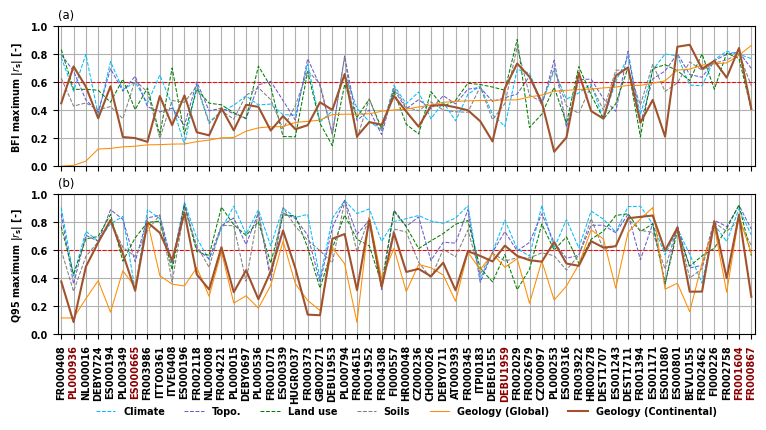

In [217]:
import matplotlib.pyplot as plt

# Create subplots with shared x-axis and y-axis
fig, axes = plt.subplots(2, 1, figsize=(9, 4), sharex=True, sharey=True)

dataframe_BFI_sorted = dataframe_BFI.sort_values(by='geoogy_global', ascending=True)
#dataframe_BFI_sorted = dataframe_BFI.sort_values(by='geology_continental', ascending=True)


# First subplot (axes[0])
axes[0].axhline(y=0.6, color='red', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['geology_continental'], label='Geology (Continental)', color='sienna')

# Customize the legend
axes[0].set_title("(a)", loc="left")
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.3, 56.3)
axes[0].set_ylabel(r'BFI maximum |$r_{\mathregular{s}}$| [-]')

# Reorder dataframe_FDC based on the sorted index of dataframe_BFI
dataframe_FDC_ordered = dataframe_FDC.loc[dataframe_BFI_sorted.index]

# Second subplot (axes[1])
axes[1].axhline(y=0.6, color='red', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['geology_continental'], label='Geology (Continental)', color='sienna')

# Rotate x-tick labels for the second subplot and set the last x-tick color to red
axes[1].tick_params(axis='x', rotation=90)
xticks = axes[1].get_xticklabels()

# Change the color of the last x-tick
if len(xticks) > 0:
    xticks[36].set_color('darkred')
    xticks[-2].set_color('darkred')
    xticks[1].set_color('darkred')
    xticks[-1].set_color('darkred')
    xticks[6].set_color('darkred')

# Apply modified x-tick labels back to the axis
axes[1].set_xticklabels(xticks)

# Customize the legend
axes[1].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.45), ncol=7)
axes[1].set_title("(b)", loc="left")
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.3, 56.3)
axes[1].set_ylabel(r'Q95 maximum |$r_{\mathregular{s}}$| [-]')

# Disable grid for second subplot
axes[1].grid(True)
axes[0].grid(True)

# Save and show the plot
plt.savefig(r'results\figs\fig_lineplot_ordered.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

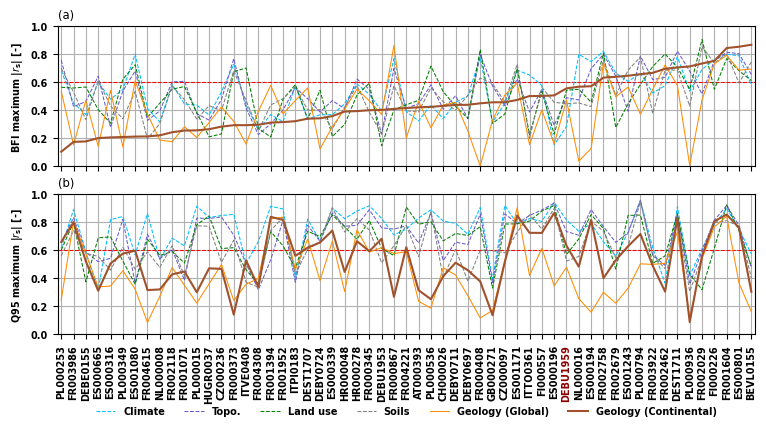

In [96]:
import matplotlib.pyplot as plt

# Create subplots with shared x-axis and y-axis
fig, axes = plt.subplots(2, 1, figsize=(9, 4), sharex=True, sharey=True)

dataframe_BFI_sorted = dataframe_BFI.sort_values(by='geoogy_global', ascending=True)
dataframe_BFI_sorted = dataframe_BFI.sort_values(by='geology_continental', ascending=True)


# First subplot (axes[0])
axes[0].axhline(y=0.6, color='red', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes[0].plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['geology_continental'], label='Geology (Continental)', color='sienna')

# Customize the legend
axes[0].set_title("(a)", loc="left")
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.3, 56.3)
axes[0].set_ylabel(r'BFI maximum |$r_{\mathregular{s}}$| [-]')

# Reorder dataframe_FDC based on the sorted index of dataframe_BFI
dataframe_FDC_ordered = dataframe_FDC.loc[dataframe_BFI_sorted.index]

# Second subplot (axes[1])
axes[1].axhline(y=0.6, color='red', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes[1].plot(dataframe_FDC_ordered.index, dataframe_FDC_ordered['geology_continental'], label='Geology (Continental)', color='sienna')

# Rotate x-tick labels for the second subplot and set the last x-tick color to red
axes[1].tick_params(axis='x', rotation=90)
xticks = axes[1].get_xticklabels()

# Change the color of the last x-tick
if len(xticks) > 0:
    xticks[41].set_color('darkred')

# Apply modified x-tick labels back to the axis
axes[1].set_xticklabels(xticks)

# Customize the legend
axes[1].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.45), ncol=7)
axes[1].set_title("(b)", loc="left")
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.3, 56.3)
axes[1].set_ylabel(r'Q95 maximum |$r_{\mathregular{s}}$| [-]')

# Disable grid for second subplot
axes[1].grid(True)
axes[0].grid(True)

# Save and show the plot
plt.savefig(r'results\figs\fig_lineplot_ordered.png', dpi=300, bbox_inches='tight')
plt.show()


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

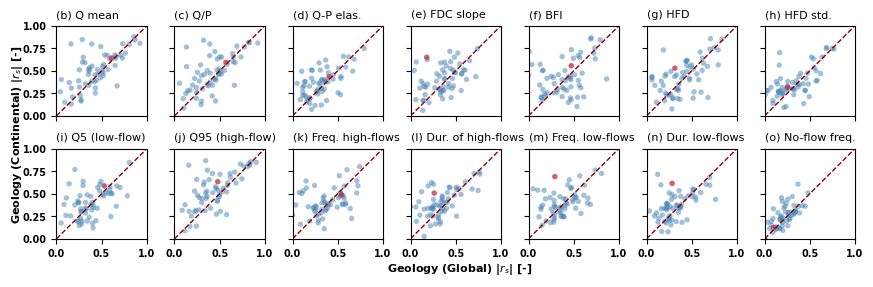

In [97]:
# Set up the figure and subplots layout: 2 rows and 7 columns (14 subplots)
fig, axes = plt.subplots(2, 7, figsize=(9, 3), sharex=True, sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()
# Create custom x labels (adjust based on your data)
custom_x_labels = [
    'Q mean', 'Q/P', 'Q-P elas.', 'FDC slope', 'BFI', 
    'HFD', 'HFD std.', 'Q5 (low-flow)', 'Q95 (high-flow)',
    'Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.'
]

# Iterate over each column and create scatter plots
for i, column in enumerate(corr_low_geology_df_25.T.columns):
    x = corr_low_geology_df_25.T[column]
    y = corr_med_geology_df_25.T[column]
    
    axes[i].plot([0, 1], [0, 1], color='darkred', linestyle='--', linewidth=1)

    # Create scatter plot for each signature
    axes[i].scatter(x, y, color='steelblue', alpha=0.5, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df_25.T[column]["DEBU1959"], corr_med_geology_df_25.T[column]["DEBU1959"], color='red', alpha=0.5, s=15, edgecolor='none')

    # Plot the y=x line
    min_val = min(min(x), min(y))
    max_val = max(max(x), max(y))

    # Set title for each subplot
    axes[i].set_title(f"({chr(98 + i)}) {custom_x_labels[i]}", fontsize=8, loc="left")
    axes[i].set_xlim(0,1)
    axes[i].set_ylim(0,1)

# Set common labels
fig.text(0.54, 0.04, "Geology (Global) |$r_s$| [-]", ha='center', fontsize=8, fontweight="bold")
fig.text(0.04, 0.5, "Geology (Continental) |$r_s$| [-]", va='center', rotation='vertical', fontsize=8, fontweight="bold")

# Adjust layout for better readability
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

fig.savefig(r'results\figs\fig_boxplots_b.png', dpi=300, bbox_inches='tight')


plt.show()

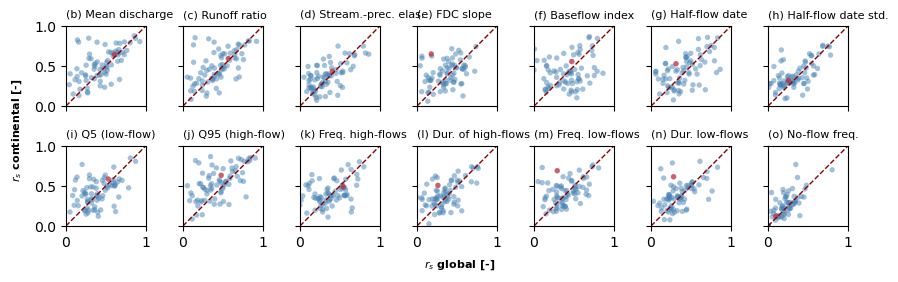

In [23]:
# Set up the figure and subplots layout: 2 rows and 7 columns (14 subplots)
fig, axes = plt.subplots(2, 7, figsize=(9, 3), sharex=True, sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()
# Create custom x labels (adjust based on your data)
custom_x_labels = [
    'Mean discharge', 'Runoff ratio', 'Stream.-prec. elas.', 'FDC slope', 'Baseflow index', 
    'Half-flow date', 'Half-flow date std.', 'Q5 (low-flow)', 'Q95 (high-flow)',
    'Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.'
]

# Iterate over each column and create scatter plots
for i, column in enumerate(corr_low_geology_df.T.columns):
    x = corr_low_geology_df.T[column]
    y = corr_med_geology_df.T[column]
    
    axes[i].plot([0, 1], [0, 1], color='darkred', linestyle='--', linewidth=1)

    # Create scatter plot for each signature
    axes[i].scatter(x, y, color='steelblue', alpha=0.5, s=15, edgecolor='none')
    axes[i].scatter(corr_low_geology_df.T[column]["DEBU1959"], corr_med_geology_df.T[column]["DEBU1959"], color='red', alpha=0.5, s=15, edgecolor='none')

    # Plot the y=x line
    min_val = min(min(x), min(y))
    max_val = max(max(x), max(y))

    # Set title for each subplot
    axes[i].set_title(f"({chr(98 + i)}) {custom_x_labels[i]}", fontsize=8, loc="left")
    axes[i].set_xlim(0,1)
    axes[i].set_ylim(0,1)

# Set common labels
fig.text(0.54, 0.04, "$r_s$ global [-]", ha='center', fontsize=8, fontweight="bold")
fig.text(0.04, 0.5, "$r_s$ continental [-]", va='center', rotation='vertical', fontsize=8, fontweight="bold")

# Adjust layout for better readability
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

fig.savefig(r'results\figs\fig_boxplots_b.png', dpi=300, bbox_inches='tight')


plt.show()

In [24]:
len(corr_max_geology_diff_abs.T[corr_max_geology_diff_abs.T.baseflow_index>=-0.1])

49

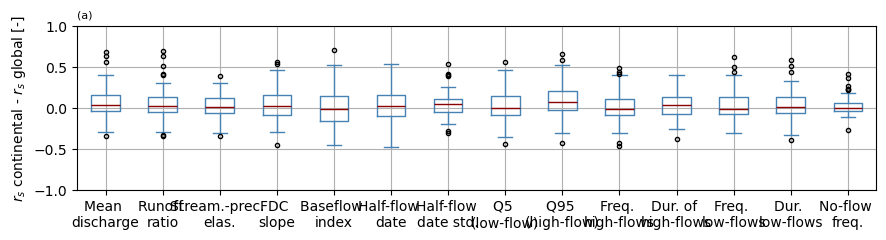

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'corr_max_geology_diff_abs' already exists as a DataFrame
df_to_plot = corr_max_geology_diff_abs.T

# Set up the figure size and layout settings
fig, ax = plt.subplots(figsize=(9, 2.5))  # Adjust the figure size as needed

# Plot the boxplot
df_to_plot.boxplot(
    ax=ax,
    boxprops=dict(color='steelblue'),    # Color for the box edges
    whiskerprops=dict(color='steelblue'), # Color for the whiskers
    capprops=dict(color='steelblue'),     # Color for the caps
    medianprops=dict(color='darkred'),  # Color for the median line
    flierprops=dict(markerfacecolor='none', marker='o', markersize=3, linestyle='none')  # Color for outliers
)
# Set y-axis limits
ax.set_ylim(-1, 1)

# Create custom x labels (adjust based on your data)
custom_x_labels = [
    'Mean \ndischarge', 'Runoff \nratio', 'Stream.-prec. \nelas.', 'FDC \nslope', 'Baseflow \nindex', 
    'Half-flow \ndate', 'Half-flow \ndate std.', 'Q5 \n(low-flow)', 'Q95 \n(high-flow)',
    'Freq. \nhigh-flows', 'Dur. of \nhigh-flows', 'Freq. \nlow-flows', 'Dur. \nlow-flows', 'No-flow \nfreq.'
]

# Set the custom x-axis labels and rotate them
#ax.set_xticks(range(1, len(df_to_plot.columns) + 1))
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center')

# Set labels and title
ax.set_ylabel(r"$r_s$ continental - $r_s$ global [-]")

ax.set_title("(a)", fontsize=8, loc="left")


# Display the plot
plt.tight_layout()  # Adjust the layout to prevent overlap

fig.savefig(r'results\figs\fig_boxplots_a.png', dpi=300, bbox_inches='tight')


plt.show()

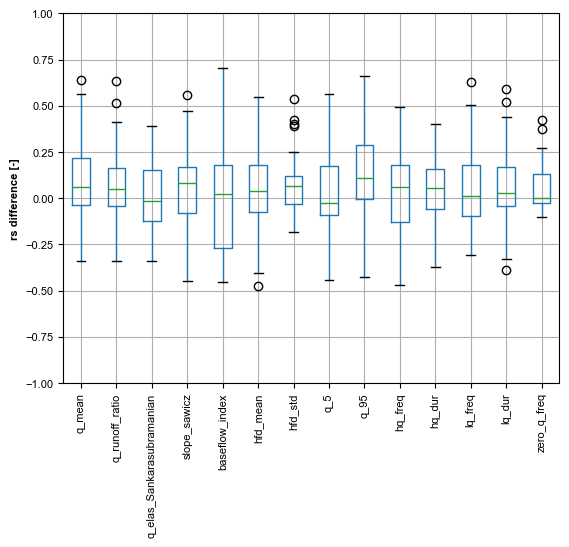

In [954]:
import matplotlib.pyplot as plt


# Convert the Series to a DataFrame and then use boxplot()
df_to_plot = corr_max_geology_diff_above_05.T  # Convert to DataFrame by using double brackets
#df_to_plot = df_to_plot.clip(lower=-10000, upper=100000)


# Assuming df_to_plot is a DataFrame already prepared
# Plot the boxplot
df_to_plot.boxplot()

# Set y-axis limits
plt.ylim(-1, 1)

# Create custom y labels (adjust based on your data)
#custom_x_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
#                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

# Set the custom x-axis labels and rotate them
plt.xticks(ticks=range(1, len(df_to_plot.columns) + 1), rotation=90)

# Display the plot
plt.ylabel("rs difference [-]")
plt.show()

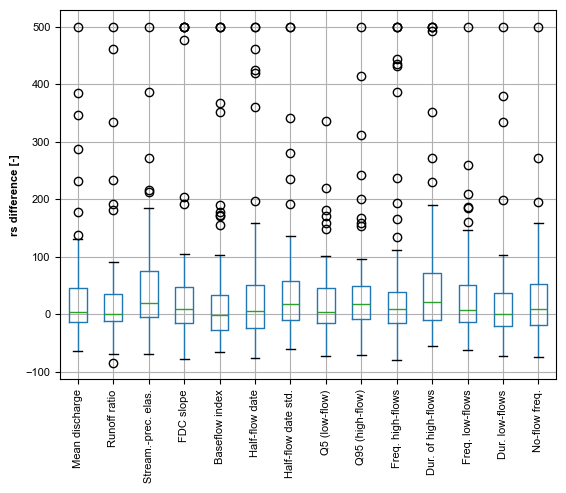

In [873]:
import matplotlib.pyplot as plt


# Convert the Series to a DataFrame and then use boxplot()
df_to_plot = corr_max_geology_diff.T  # Convert to DataFrame by using double brackets
df_to_plot = df_to_plot.clip(lower=-500, upper=500)


# Assuming df_to_plot is a DataFrame already prepared
# Plot the boxplot
df_to_plot.boxplot()

# Set y-axis limits
#plt.ylim(-1, 1)

# Create custom y labels (adjust based on your data)
custom_x_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

# Set the custom x-axis labels and rotate them
plt.xticks(ticks=range(1, len(df_to_plot.columns) + 1), labels=custom_x_labels, rotation=90)

# Display the plot
plt.ylabel("rs difference [-]")
plt.show()



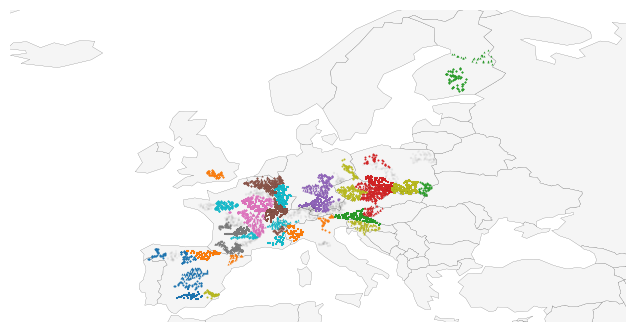

In [99]:
list_cats_list = ['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000271', 'ITTO0361', 'ITVE0408', 'ITPI0183',
       'FI000557', 'FI000226', 'PL000936', 'PL000794', 'HR000048', 'HUGR0037',
       'AT000393', 'PL000253', 'PL000349', 'PL000015', 'CZ000097', 'DEST1711',
       'DEBY0711', 'DEBY0724', 'DEBY0697', 'DEBU1953', 'NL000008', 'CH000026',
       'FR002679', 'FR004615', 'NL000016', 'BEVL0155', 'FR000408', 'FR000373',
       'FR000345', 'FR001071', 'FR003922', 'FR003986', 'FR002118', 'FR001952',
       'FR002029', 'FR001604', 'FR004221', 'ES001171', 'PL000536', 'HR000278',
       'CZ000236', 'DEST1707', 'DEBE0155', 'FR002758', 'FR002462', 'FR001394',
       'FR000867', 'FR004308', 'DEBU1959']

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs_all = {}

for catchment in list_cats_list:
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs_all[catchment] = cat_clip

# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_dfs_all, figsize=(8, 6), ax=axes, 
                      title_plot='', limits_europe = True)

In [100]:
# Concatenate all DataFrames inside the dictionary
df_concatenated = pd.concat(estreams_attributes_dfs_all.values(), ignore_index=True)
df_concatenated

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_ff2,perm_medium_ff2,perm_lower_ff2,perm_impermeable_ff2
0,4004,"CUBETA, LA",ES,ES_CEDEX,NaN,-2.893303,38.977562,-2.893303,38.977562,758,...,2.24,14.52,0.477,24.162,70.401,0.0,NaN,NaN,NaN,NaN
1,4008,BALBUENA O VALBUENA,ES,ES_CEDEX,NaN,-4.115169,38.893002,-4.115169,38.893002,558,...,37.49,292.91,0.285,1283.229,3137.197,3.0,NaN,NaN,NaN,NaN
2,4009,LUCIANA,ES,ES_CEDEX,NaN,-4.307002,38.982834,-4.307002,38.982834,525,...,52.05,478.39,0.277,1307.844,3249.732,3.0,NaN,NaN,NaN,NaN
3,4012,GARCIA SOLA,ES,ES_CEDEX,NaN,-5.182132,39.138890,-5.182132,39.138890,318,...,106.78,2770.62,0.257,1308.005,3312.137,3.0,NaN,NaN,NaN,NaN
4,4101,VALLEHERMOSO,ES,ES_CEDEX,NaN,-3.150313,38.845982,-3.150313,38.845982,742,...,0.00,0.00,0.305,4.267,35.701,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,1.80,62.62,5.680,0.045,0.045,25.0,1.917023,0.000000,0.000000,98.082977
4297,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.00,0.00,2.863,0.004,0.009,15.0,14.327884,32.255374,53.416742,0.000000
4298,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,2.67,67.85,4.753,1.641,4.770,78.0,18.753136,5.872553,24.977481,50.396831
4299,5,Schoenfels,LU,LU_CONTACTFORM,Mamer,6.100795,49.723112,6.100795,49.723112,NaN,...,0.00,0.00,3.184,0.015,0.015,17.0,39.499138,0.000000,60.500862,0.000000


In [101]:
len(estreams_attributes_dfs_all.keys())

57

In [102]:
df_concatenated.dam_num.max()

93.0

In [104]:
dataframe_BFI_sorted

,geoogy_global,geology_continental,climate,soils,topography,landuse,max,area,dams,lakes,len
PL000253,0.536456,0.104524,0.685397,0.700560,0.758616,0.564781,0.758616,31600.000,1.0,325.0,60.0
FR003986,0.153664,0.175053,0.450771,0.529912,0.426492,0.559718,0.559718,20819.208,21.0,178.0,95.0
DEBE0155,0.471989,0.178103,0.370001,0.333493,0.463148,0.566605,0.566605,12253.909,3.0,346.0,50.0
ES000665,0.143943,0.201949,0.601525,0.613951,0.643886,0.405535,0.643886,32359.392,43.0,42.0,43.0
ES000316,0.542879,0.206789,0.479856,0.431828,0.279395,0.307993,0.479856,25155.699,25.0,30.0,76.0
PL000349,0.139161,0.209644,0.548459,0.340629,0.537620,0.622306,0.622306,16500.000,1.0,445.0,35.0
ES001080,0.610800,0.212546,0.802173,0.535189,0.681117,0.726062,0.802173,15650.545,32.0,32.0,39.0
FR004615,0.372607,0.214057,0.413984,0.196069,0.328155,0.351192,0.413984,26198.013,6.0,102.0,139.0
NL000008,0.187632,0.221621,0.317964,0.305577,0.396629,0.451518,0.451518,26066.728,23.0,92.0,181.0
FR002118,0.176321,0.243572,0.583729,0.574456,0.603390,0.551032,0.603390,7394.765,2.0,10.0,32.0


array([[<Axes: title={'center': 'q_mean'}>,
        <Axes: title={'center': 'q_runoff_ratio'}>,
        <Axes: title={'center': 'q_elas_Sankarasubramanian'}>,
        <Axes: title={'center': 'slope_sawicz'}>],
       [<Axes: title={'center': 'baseflow_index'}>,
        <Axes: title={'center': 'hfd_mean'}>,
        <Axes: title={'center': 'hfd_std'}>,
        <Axes: title={'center': 'q_5'}>],
       [<Axes: title={'center': 'q_95'}>,
        <Axes: title={'center': 'hq_freq'}>,
        <Axes: title={'center': 'hq_dur'}>,
        <Axes: title={'center': 'lq_freq'}>],
       [<Axes: title={'center': 'lq_dur'}>,
        <Axes: title={'center': 'zero_q_freq'}>, <Axes: >, <Axes: >]],
      dtype=object)

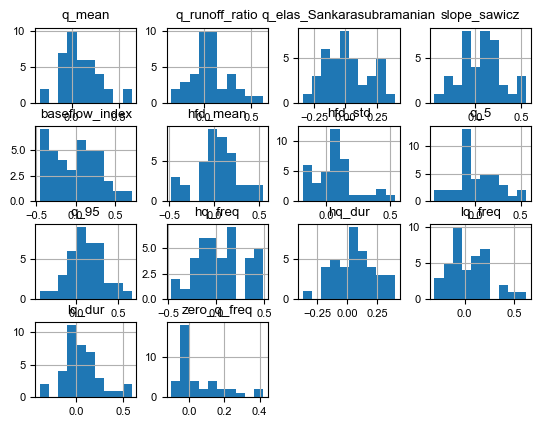

In [957]:
df_to_plot.hist()


array([[<Axes: title={'center': 'q_mean'}>,
        <Axes: title={'center': 'q_runoff_ratio'}>,
        <Axes: title={'center': 'q_elas_Sankarasubramanian'}>,
        <Axes: title={'center': 'slope_sawicz'}>],
       [<Axes: title={'center': 'baseflow_index'}>,
        <Axes: title={'center': 'hfd_mean'}>,
        <Axes: title={'center': 'hfd_std'}>,
        <Axes: title={'center': 'q_5'}>],
       [<Axes: title={'center': 'q_95'}>,
        <Axes: title={'center': 'hq_freq'}>,
        <Axes: title={'center': 'hq_dur'}>,
        <Axes: title={'center': 'lq_freq'}>],
       [<Axes: title={'center': 'lq_dur'}>,
        <Axes: title={'center': 'zero_q_freq'}>, <Axes: >, <Axes: >]],
      dtype=object)

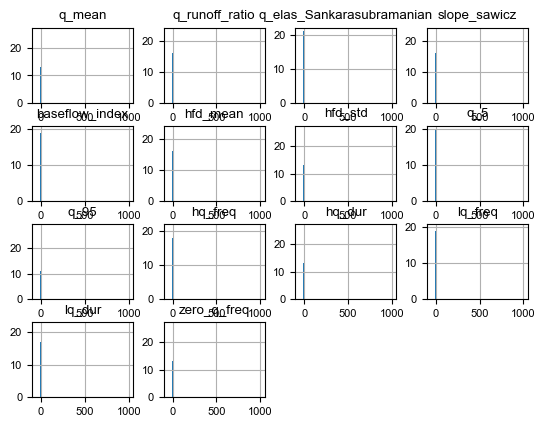

In [958]:
df_to_plot.hist(bins=[-50,-40, -30,-20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 1000])


In [537]:
corr_max_group_dfs_dict["ES000194"]

,q_mean,q_runoff_ratio,q_elas_Sankarasubramanian,slope_sawicz,baseflow_index,hfd_mean,hfd_std,q_5,q_95,hq_freq,hq_dur,lq_freq,lq_dur,zero_q_freq
corr_max_climatic,-0.852793,-0.744027,-0.499194,0.502117,0.748084,0.213306,-0.598063,-0.790654,-0.790201,0.615990,0.584594,0.498740,-0.390813,-0.431971
corr_max_geology_low,-0.160287,-0.132258,0.136958,-0.292615,0.128278,0.107913,0.154296,-0.295317,-0.158085,-0.117339,0.123058,-0.281141,-0.370161,-0.342459
corr_max_geology_med,-0.799879,-0.764516,0.381048,-0.467725,0.572327,0.151124,-0.274360,-0.637263,-0.817339,-0.531291,-0.522679,-0.507710,0.359839,-0.301759
corr_max_geology_high,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
corr_max_lulc,-0.835568,-0.788306,0.473435,0.279839,0.458077,-0.186037,-0.571450,0.582955,-0.856048,-0.454463,0.456699,-0.279902,-0.561234,-0.229587
corr_max_soil,-0.791209,-0.746371,-0.462547,0.487097,0.427310,0.149194,-0.394920,-0.594066,-0.808871,-0.518399,-0.650670,0.487500,0.425403,-0.387535
corr_max_topography,-0.901905,-0.825806,-0.468548,-0.400000,0.697862,-0.105274,-0.451613,0.713565,-0.890726,-0.601210,-0.593548,-0.553629,-0.529839,-0.478111


In [ ]:
GB000271,FR000408,FR003812,FR003919,FR004221*,FR001604*,(FR004239), ES000664,ES000325*, ES000422,ITTO0398,FI000557,PL000536*
    PL000533, HR000280*,HR000280*, HR000274,HR000103,PL001058,PL000936,PL000532,PL000536**,PL000794,DEBW0186,
    DEBY0833*,DEBU1953,FR002291,FR002209, FR002679,ES000194,ES000196,ES001334,ES000705,PT000239,
PT000006, PT000125,GB000271, GB000472, GB000306,FR003819,BEVL0155,NL000016,BEWA0027,PL000256,ITVE0408,ITPI0170*, ITPI0220,
ITGR0001,ITLC0146,ES000558,CZ000097,CZ000178,DEBY0711,DEBY0719,DEBY0724

DEST1711, 
    
Improved
FR001071,FR000374,FR003870,FR003984,FR003978,FR003954, HR000047,HR000127,HR000174,HUGR0037,CZ000464*, AT000393
    AT000389,FR002464, FR003986, no difference
FR000325,ES001171,ITPI0183,DK000165,FR004651,FR002758,DEST1707,DEBE0155,CZ000219,  decreased
FI000137,ES000796, both


Impression there are dams: ES001080, IEOP0060

In [521]:
From 7,000 - 35,000
paying attention on the number of years

ES000801, ES000665,ES001243, ES000196, ES000116, ES000194, ES001080, ES000316,ES000397,ES000339,ES000331, GB000472, GB000271, GB000153,ITTO0361,
ITVE0408,ITLC0146, ITPI0183, SE000102, FI000668, FI000585, FI000557, FI000226, FI000137, LTGR0031, PL000936,PL000905, PL000868, PL000794,HR000048,
HUGR0037, AT000393, PL000253, PL000349, PL000015,CZ000097,DEST1711, DEBY0711,DEBY0724, DEBY0697, DEBU1953, NL000008,CH000026, FR002679, FR004615,
NL000016, BEVL0155, FR000408, FR000373, FR000345, FR001071, FR003922, FR003986, FR002118, FR001952,FR002029, FR001604, FR004221, 


ES000738,ES001171, ES001010, PL001056, PL000536, HR000278, CZ000236,DEST1707, DEBE0155,FR002758,FR002462,FR001394, FR000867, FR004308, 




A<7000 AT000279

In [ ]:
list_cats_list = ["ES000801", "ES000665","ES001243", "ES000196", "ES000116", "ES000194", "ES001080", "ES000316","ES000397","ES000339","ES000331", 
                  "GB000472", "GB000271", "GB000153","ITTO0361","ITVE0408","ITLC0146", "ITPI0183", "SE000102", "FI000668", "FI000585", "FI000557", 
                  "FI000226", "FI000137", "LTGR0031", "PL000936","PL000905", "PL000868", "PL000794","HR000048","HUGR0037", "AT000393", "PL000253", 
                  "PL000349", "PL000015","CZ000097","DEST1711", "DEBY0711","DEBY0724", "DEBY0697", "DEBU1953", "NL000008","CH000026", "FR002679", 
                  "FR004615", "NL000016", "BEVL0155", "FR000408", "FR000373", "FR000345", "FR001071", "FR003922", "FR003986", "FR002118", "FR001952",
                  "FR002029", "FR001604", "FR004221", "ES000738","ES001171", "ES001010", "PL001056", "PL000536", "HR000278", "CZ000236","DEST1707", 
                  "DEBE0155","FR002758","FR002462","FR001394", "FR000867", "FR004308", "DEBU1959"] 

In [206]:
dataframe_BFI["area"] = estreams_attributes.loc[list_cats_list, :].area_estreams
dataframe_BFI["dams"] = estreams_attributes.loc[list_cats_list, :].res_num
dataframe_BFI["lakes"] = estreams_attributes.loc[list_cats_list, :].lakes_num
dataframe_BFI["len"] = lens_df.T

dataframe_BFI_filt = dataframe_BFI[dataframe_BFI.len >= 30]


dataframe_BFI_filt.head(60)

,geoogy_global,geology_continental,climate,soils,topography,landuse,max,area,dams,lakes,len
ES000801,0.687922,0.854495,0.789886,0.596007,0.804415,0.683436,0.804415,26470.566,18.0,58.0,34.0
ES000665,0.143943,0.201949,0.601525,0.613951,0.643886,0.405535,0.643886,32359.392,43.0,42.0,43.0
ES001243,0.566669,0.647460,0.478640,0.686662,0.393601,0.447211,0.686662,33576.944,58.0,46.0,94.0
ES000196,0.160147,0.506889,0.317109,0.457152,0.292403,0.230063,0.457152,15578.353,12.0,9.0,37.0
ES000194,0.128278,0.572327,0.748084,0.427310,0.697862,0.458077,0.748084,14406.755,14.0,17.0,33.0
ES001080,0.610800,0.212546,0.802173,0.535189,0.681117,0.726062,0.802173,15650.545,32.0,32.0,39.0
ES000316,0.542879,0.206789,0.479856,0.431828,0.279395,0.307993,0.479856,25155.699,25.0,30.0,76.0
ES000339,0.284110,0.359208,0.369394,0.267001,0.469774,0.213195,0.469774,12929.504,31.0,31.0,37.0
GB000271,0.330321,0.457553,0.316714,0.590515,0.574471,0.307028,0.590515,9937.208,12.0,111.0,40.0
GB000153,0.463934,0.199602,0.409222,0.584557,0.236093,0.404698,0.584557,8215.227,13.0,60.0,30.0


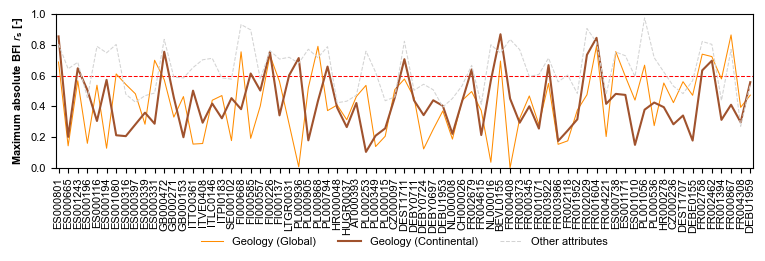

In [159]:

# Create the plot


plt.figure(figsize=(9, 2.0))

# Add a straight horizontal line at y=0.7
plt.axhline(y=0.6, color='red', linestyle='--', linewidth=0.75)

plt.plot(dataframe_BFI.index, dataframe_BFI['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
plt.plot(dataframe_BFI.index, dataframe_BFI['geology_continental'], label='Geology (Continental)', color='sienna')
#plt.plot(dataframe_BFI.index, dataframe_BFI['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.5)
#plt.plot(dataframe_BFI.index, dataframe_BFI['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.5)
#plt.plot(dataframe_BFI.index, dataframe_BFI['landuse'], label='Land use', color='palegreen', linestyle='--', linewidth=0.5)
#plt.plot(dataframe_BFI.index, dataframe_BFI['soils'], label='Soils', color='black', linestyle='--', linewidth=0.5)
plt.plot(dataframe_BFI.index, dataframe_BFI['max'], label='Other attributes', color='lightgray', linestyle='--', linewidth=0.75)

# Rotate x-axis labels
plt.xticks(rotation=90)



# Customize legend
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.38), ncol=7)

# Set y-axis limits
plt.ylim(0, 1)
plt.xlim(-0.3, 72.3)
plt.ylabel(r'Maximum absolute BFI $r_{\mathregular{s}}$ [-]')

plt.grid(False)

# Display the plot
plt.show()

In [185]:
dataframe_BFI[dataframe_BFI.len >= 20]

,geoogy_global,geology_continental,climate,soils,topography,landuse,max,area,dams,lakes,len
ES000801,0.687922,0.854495,0.789886,0.596007,0.804415,0.683436,0.804415,26470.566,18.0,58.0,34.0
ES000665,0.143943,0.201949,0.601525,0.613951,0.643886,0.405535,0.643886,32359.392,43.0,42.0,43.0
ES001243,0.566669,0.647460,0.478640,0.686662,0.393601,0.447211,0.686662,33576.944,58.0,46.0,94.0
ES000196,0.160147,0.506889,0.317109,0.457152,0.292403,0.230063,0.457152,15578.353,12.0,9.0,37.0
ES000194,0.128278,0.572327,0.748084,0.427310,0.697862,0.458077,0.748084,14406.755,14.0,17.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...
FR002462,0.723443,0.696822,0.575630,0.686960,0.636229,0.802886,0.802886,20551.737,29.0,81.0,88.0
FR001394,0.578368,0.312587,0.355014,0.438654,0.303940,0.209886,0.438654,22175.954,1.0,68.0,91.0
FR000867,0.864042,0.410566,0.769429,0.575837,0.699590,0.404405,0.769429,10146.529,5.0,59.0,45.0
FR004308,0.393606,0.296933,0.261146,0.254569,0.226845,0.270578,0.270578,10748.554,14.0,12.0,55.0


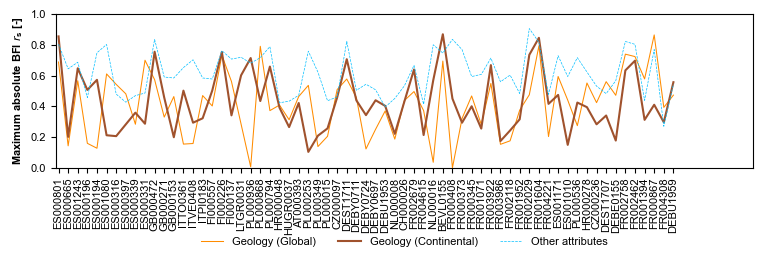

In [186]:
dataframe_BFI_filt = dataframe_BFI[dataframe_BFI.len >= 20]
# Create the plot
plt.figure(figsize=(9, 2.0))
plt.plot(dataframe_BFI_filt.index, dataframe_BFI_filt['geoogy_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
plt.plot(dataframe_BFI_filt.index, dataframe_BFI_filt['geology_continental'], label='Geology (Continental)', color='sienna')
#plt.plot(dataframe_BFI_filt.index, dataframe_BFI_filt['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.5)
#plt.plot(dataframe_BFI_filt.index, dataframe_BFI_filt['topography'], label='Topo.', color='slateblue', linestyle='--', linewidth=0.5)
#plt.plot(dataframe_BFI_filt.index, dataframe_BFI_filt['landuse'], label='Land use', color='palegreen', linestyle='--', linewidth=0.5)
#plt.plot(dataframe_BFI_filt.index, dataframe_BFI_filt['soils'], label='Soils', color='black', linestyle='--', linewidth=0.5)
plt.plot(dataframe_BFI_filt.index, dataframe_BFI_filt['max'], label='Other attributes', color='deepskyblue', linestyle='--', linewidth=0.5)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a straight horizontal line at y=0.7
#plt.axhline(y=0.7, color='black', linestyle='--', linewidth=0.75)

# Customize legend
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.38), ncol=7)

# Set y-axis limits
plt.ylim(0, 1)
plt.xlim(-0.3, 72.3)
plt.ylabel(r'Maximum absolute BFI $r_{\mathregular{s}}$ [-]')

plt.grid(False)

# Display the plot
plt.show()

In [168]:
# Here we filter the list of nested_catchments according to this first filter:
list_cats = ["ES000738"]

100%|██████████| 1/1 [00:00<?, ?it/s]


           len
ES000738  16.0


100%|██████████| 14/14 [00:00<00:00, 92.44it/s]


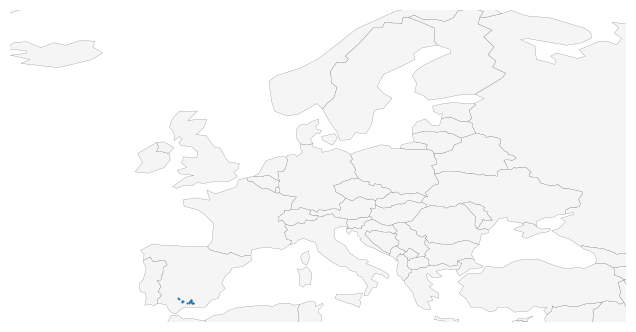

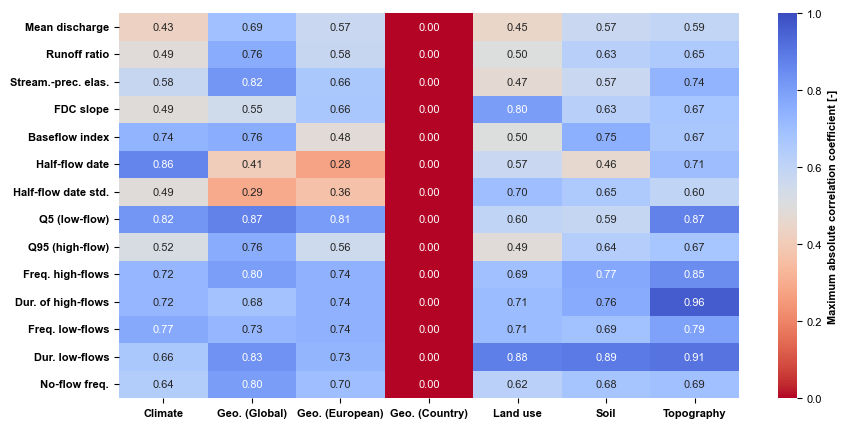

In [169]:

nested_cats_df = nested_catchments.loc[list_cats, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 
# Filter only the catchemnts using the function stated before:
nested_cats_filtered = find_max_unique_rows(nested_cats_df)

# Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]


# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip



# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)


# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]
print(nested_cats_filtered_abovevalue)


# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='', limits_europe = True)


estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]


# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perc_imp','perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 
       'perm_impermeable_euro', 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
       "perm_impermeable_ff2", "perm_lower_ff2", "perm_medium_ff2", "perm_high_ff2",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Assuming correlation_dict is a dictionary containing all correlation DataFrames
# Initialize an empty list to store individual correlation DataFrames
correlation_list = []

# Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
for signature in correlation_dict.keys():
    corr_df = correlation_dict[signature].T
    corr_df['signature'] = signature  # Add a column to identify the signature
    correlation_list.append(corr_df)

# Concatenate all correlation DataFrames along the rows
combined_correlation_df = pd.concat(correlation_list)

# Preserve the order of the signatures by converting to categorical type
combined_correlation_df['signature'] = pd.Categorical(
    combined_correlation_df['signature'],
    categories=list(correlation_dict.keys()),
    ordered=True
)

# Set the signature column as the index
combined_correlation_df.set_index('signature', inplace=True)

# Customize row names (for demonstration purposes, modify as needed)
#custom_row_names = ['Row ' + str(i) for i in range(1, len(combined_correlation_df.index) + 1)]
#combined_correlation_df.index = custom_row_names

# Plot the combined heatmap
#plt.figure(figsize=(20, 16))
#sns.heatmap(combined_correlation_df, annot=False, cmap='coolwarm', fmt=".1f", vmin=-1, vmax=1, 
#            cbar_kws={'label': 'Correlation Coefficient'}, 
#            yticklabels=combined_correlation_df.index)
#
##plt.title('Combined Heatmap for All Signatures', fontsize=20)
##plt.xlabel('Variables', fontsize=15)
#plt.ylabel('', fontsize=15)

## Customize font sizes
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#
#plt.show()


# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'topography',
    'ele_mt_mean': 'topography',
    'ele_mt_min': 'topography',
    'slp_dg_mean': 'topography',
    'flat_area_fra': 'topography',
    'steep_area_fra': 'topography',
    'elon_ratio': 'topography',
    'strm_dens': 'topography',
    'lit_dom': 'geology',
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "topography"
}


# Select the variable
signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
              'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

corr_max_group_dfs = pd.DataFrame(columns = signatures)

for signature in signatures:
    correlation_df = correlation_dict[signature]
    
    # Initialize the dataframe with columns for each class's maximum correlation and feature
    columns = []
    for cls in classes:
        columns.append(f"corr_max_{cls}")
        columns.append(f"corr_max_feature_{cls}")

    corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

    # Populate the dataframe with the maximum correlations for each class
    for catchment in correlation_df.columns:
        max_corr = {cls: 0 for cls in classes}
        max_feature = {cls: None for cls in classes}

        for feature in correlation_df.index:
            cls = variable_dict[feature]
            corr_value = abs(correlation_df.loc[feature, catchment])

            if corr_value > abs(max_corr[cls]):
                max_corr[cls] = correlation_df.loc[feature, catchment]
                max_feature[cls] = feature

        for cls in classes:
            corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
            corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

    # Reclassify geological classes using the mapping dictionary for each class's feature
    for cls in classes:
        corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

    corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                      'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                      'corr_max_vegetation', 'corr_max_hydrology']]

    # Sort and add additional columns
    corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
    corr_max_group_df = corr_max_group_df.astype(float)
    corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
    corr_max_group_dfs[signature] = corr_max_group_df


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

corr_max_group_dfs_abs = corr_max_group_dfs.abs()
# Plot the heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(corr_max_group_dfs_abs.T, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=0, vmax=1, alpha=1)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Maximum absolute correlation coefficient [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
#plt.savefig(r'results\figs\fig_paper_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()



100%|██████████| 1/1 [00:00<00:00, 588.76it/s]


           len
ES000738  16.0


100%|██████████| 14/14 [00:00<00:00, 81.10it/s]


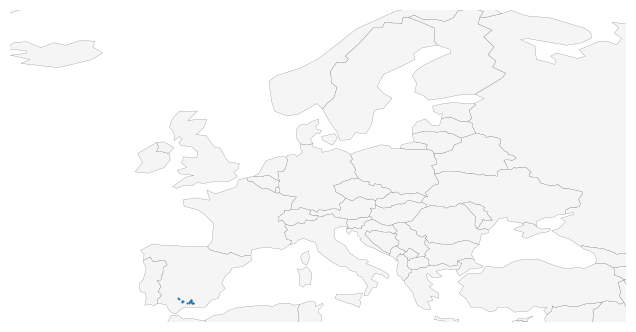

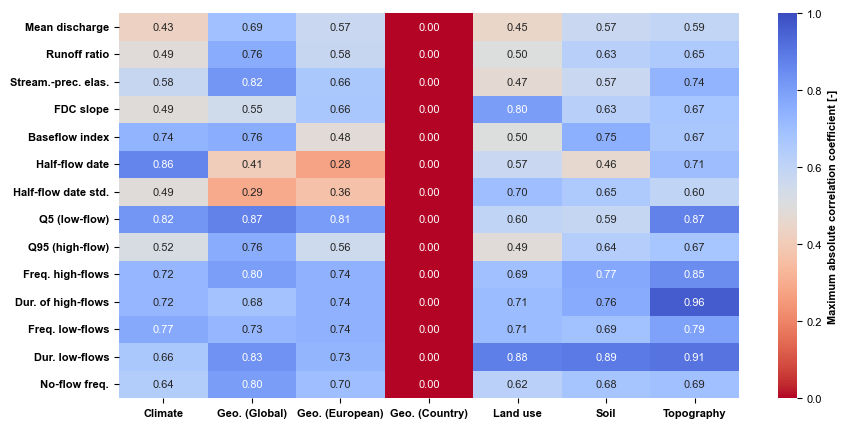

In [170]:

nested_cats_df = nested_catchments.loc[list_cats, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 
# Filter only the catchemnts using the function stated before:
nested_cats_filtered = find_max_unique_rows(nested_cats_df)

# Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]


# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip



# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)


# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]
print(nested_cats_filtered_abovevalue)


# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='', limits_europe = True)


estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]


# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perc_imp','perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 
       'perm_impermeable_euro', 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
       "perm_impermeable_ff2", "perm_lower_ff2", "perm_medium_ff2", "perm_high_ff2",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Assuming correlation_dict is a dictionary containing all correlation DataFrames
# Initialize an empty list to store individual correlation DataFrames
correlation_list = []

# Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
for signature in correlation_dict.keys():
    corr_df = correlation_dict[signature].T
    corr_df['signature'] = signature  # Add a column to identify the signature
    correlation_list.append(corr_df)

# Concatenate all correlation DataFrames along the rows
combined_correlation_df = pd.concat(correlation_list)

# Preserve the order of the signatures by converting to categorical type
combined_correlation_df['signature'] = pd.Categorical(
    combined_correlation_df['signature'],
    categories=list(correlation_dict.keys()),
    ordered=True
)

# Set the signature column as the index
combined_correlation_df.set_index('signature', inplace=True)

# Customize row names (for demonstration purposes, modify as needed)
#custom_row_names = ['Row ' + str(i) for i in range(1, len(combined_correlation_df.index) + 1)]
#combined_correlation_df.index = custom_row_names

# Plot the combined heatmap
#plt.figure(figsize=(20, 16))
#sns.heatmap(combined_correlation_df, annot=False, cmap='coolwarm', fmt=".1f", vmin=-1, vmax=1, 
#            cbar_kws={'label': 'Correlation Coefficient'}, 
#            yticklabels=combined_correlation_df.index)
#
##plt.title('Combined Heatmap for All Signatures', fontsize=20)
##plt.xlabel('Variables', fontsize=15)
#plt.ylabel('', fontsize=15)

## Customize font sizes
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#
#plt.show()


# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'topography',
    'ele_mt_mean': 'topography',
    'ele_mt_min': 'topography',
    'slp_dg_mean': 'topography',
    'flat_area_fra': 'topography',
    'steep_area_fra': 'topography',
    'elon_ratio': 'topography',
    'strm_dens': 'topography',
    'lit_dom': 'geology',
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "topography"
}


# Select the variable
signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
              'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

corr_max_group_dfs = pd.DataFrame(columns = signatures)

for signature in signatures:
    correlation_df = correlation_dict[signature]
    
    # Initialize the dataframe with columns for each class's maximum correlation and feature
    columns = []
    for cls in classes:
        columns.append(f"corr_max_{cls}")
        columns.append(f"corr_max_feature_{cls}")

    corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

    # Populate the dataframe with the maximum correlations for each class
    for catchment in correlation_df.columns:
        max_corr = {cls: 0 for cls in classes}
        max_feature = {cls: None for cls in classes}

        for feature in correlation_df.index:
            cls = variable_dict[feature]
            corr_value = abs(correlation_df.loc[feature, catchment])

            if corr_value > abs(max_corr[cls]):
                max_corr[cls] = correlation_df.loc[feature, catchment]
                max_feature[cls] = feature

        for cls in classes:
            corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
            corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

    # Reclassify geological classes using the mapping dictionary for each class's feature
    for cls in classes:
        corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

    corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                      'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                      'corr_max_vegetation', 'corr_max_hydrology']]

    # Sort and add additional columns
    corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
    corr_max_group_df = corr_max_group_df.astype(float)
    corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
    corr_max_group_dfs[signature] = corr_max_group_df


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

corr_max_group_dfs_abs = corr_max_group_dfs.abs()
# Plot the heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(corr_max_group_dfs_abs.T, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=0, vmax=1, alpha=1)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Maximum absolute correlation coefficient [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
#plt.savefig(r'results\figs\fig_paper_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()



In [789]:
((corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"])/corr_max_group_dfs_abs.T["corr_max_geology_low"])*100

q_mean                       -2.512491
q_runoff_ratio               15.467761
q_elas_Sankarasubramanian    30.773300
slope_sawicz                 10.218339
baseflow_index               47.883133
hfd_mean                     -1.740071
hfd_std                     -36.007866
q_5                          26.095700
q_95                         25.350208
hq_freq                      35.202797
hq_dur                       26.012334
lq_freq                     -19.187478
lq_dur                        5.601981
zero_q_freq                  98.746569
dtype: float64

In [102]:
correlation_dict["baseflow_index"].loc[["perc_imp", "perc_low_perm", "perc_medium_perm", "perc_high_perm",
  "perm_impermeable_euro", "perm_lower_euro", "perm_medium_euro", "perm_high_euro"]]

,FR001604
perc_imp,0.793300
perc_low_perm,0.681887
perc_medium_perm,-0.630237
perc_high_perm,0.176471
perm_impermeable_euro,0.775352
perm_lower_euro,0.571028
perm_medium_euro,-0.845185
perm_high_euro,-0.103824


In [103]:
estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]
estreams_attributes_dfs_cat

df = cat_clip.loc[cat_clip[cat_clip.area_estreams > 0].index]
df["area_estreams_log"] = np.log(df.area_estreams)

In [104]:
df = estreams_attributes_dfs[catchment]
df = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]


In [105]:
df.loc[:, ["perm_high_euro", "baseflow_index"]].corr(method="spearman")

,perm_high_euro,baseflow_index
perm_high_euro,1.000000,-0.103824
baseflow_index,-0.103824,1.000000


In [106]:
df.loc[:, ["perc_high_perm", "baseflow_index"]].corr(method="spearman")

,perc_high_perm,baseflow_index
perc_high_perm,1.000000,0.176471
baseflow_index,0.176471,1.000000


In [107]:
df["relief"] = df["ele_mt_max"] - df["ele_mt_min"] 
df.loc[:, ["relief", "baseflow_index"]].corr(method="spearman")

,relief,baseflow_index
relief,1.000000,0.805588
baseflow_index,0.805588,1.000000


Plot some map parts:

In [116]:
GLiM = gpd.read_file("../estreams_part_b/data/lithology/GLiM.shp")

attribute_field = 'xx'
GLiM_dissolved = GLiM.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
GLiM_dissolved["class"] = GLiM_dissolved.index

GLiM_dissolved

,geometry,OBJECTID,IDENTITY_,Litho,Shape_Leng,Shape_Area,class
xx,,,,,,,
ev,"MULTIPOLYGON (((796612.255 4303804.029, 794661...",934081.0,AFR523,ev____,5.047309e+04,6.513290e+07,ev
ig,"MULTIPOLYGON (((575196.412 5659697.793, 575336...",921749.0,GRL535,ig____,6.467270e+07,1.697807e+12,ig
mt,"MULTIPOLYGON (((-764553.738 4693621.364, -7645...",376782.0,AFR591,mt____,1.387856e+05,5.205213e+08,mt
nd,"MULTIPOLYGON (((700251.625 6039527.249, 700077...",1110327.0,TUR4883,nd____,1.914590e+03,2.272265e+05,nd
pa,"MULTIPOLYGON (((-809472.759 4869757.421, -8094...",376864.0,AFR771,pa____,6.997871e+05,2.273725e+09,pa
pb,"MULTIPOLYGON (((-647661.709 4211164.200, -6493...",376807.0,AFR669,pb__vr,1.666877e+05,7.185591e+08,pb
pi,"MULTIPOLYGON (((-731155.004 4704819.954, -7317...",392850.0,FRA4091,pi__mt,4.941481e+04,3.576686e+07,pi
py,"MULTIPOLYGON (((-547556.865 4767878.253, -5472...",409551.0,ESP12223,py____,1.146299e+04,8.731417e+06,py
sc,"MULTIPOLYGON (((-760132.638 4215995.713, -7604...",376748.0,AFR450,scpu__,7.800228e+04,1.827193e+08,sc


In [117]:
print("CRS of GLiM:", GLiM_dissolved.crs)
GLiM_reprojected = GLiM_dissolved.to_crs("EPSG:4326")

CRS of GLiM: PROJCS["World_Eckert_IV",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Eckert_IV"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54012"]]


In [ ]:
attribute_field = 'LEVEL3'
IHME_dissolved = IHME.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
IHME_dissolved["class"] = IHME_dissolved.index

IHME_dissolved

In [142]:
IHME = gpd.read_file("../estreams_part_b/data/lithology/ihme1500_litho12345_ec4060_v12_poly.shp")
IHME

,LEVEL1,LEVEL2,LEVEL3,LEVEL4,LEVEL5,Shape_Leng,Shape_Area,geometry
0,Calcarenites and sands,Sandstones and sands,Sandstones and sands,Siliciclastic rocks and coarse sediments,Partly consolidated materials,16157.349185,9.785184e+06,"POLYGON ((6450346.152 1662977.496, 6450152.889..."
1,Calcarenites and sands,Sandstones and sands,Sandstones and sands,Siliciclastic rocks and coarse sediments,Partly consolidated materials,11078.646746,3.834742e+06,"POLYGON ((6481132.818 1676278.005, 6481141.404..."
2,Calcarenites and sands,Sandstones and sands,Sandstones and sands,Siliciclastic rocks and coarse sediments,Partly consolidated materials,49874.406064,7.178618e+07,"POLYGON ((6442279.168 1664929.960, 6442669.438..."
3,Calcarenites and sands,Sandstones and sands,Sandstones and sands,Siliciclastic rocks and coarse sediments,Partly consolidated materials,29631.111903,2.505152e+07,"POLYGON ((6449860.296 1673180.390, 6449244.404..."
4,Calcarenites and sands,Sandstones and sands,Sandstones and sands,Siliciclastic rocks and coarse sediments,Partly consolidated materials,150120.304888,3.297889e+08,"POLYGON ((6485944.068 1681420.555, 6486333.536..."
...,...,...,...,...,...,...,...,...
77112,"Volcanic rocks, shales, sandstones, conglomera...",Volcanic rocks,Volcanic rocks,Magmatic rocks,Consolidated materials,4768.658088,1.272874e+06,"POLYGON ((5171308.436 2174642.778, 5170573.064..."
77113,"Volcanic rocks, shales, sandstones, conglomera...",Volcanic rocks,Volcanic rocks,Magmatic rocks,Consolidated materials,9312.551195,3.525781e+06,"POLYGON ((5169018.937 2173873.656, 5168809.121..."
77114,"Volcanic rocks, shales, sandstones, conglomera...",Volcanic rocks,Volcanic rocks,Magmatic rocks,Consolidated materials,13710.318736,9.413435e+06,"POLYGON ((5163384.636 2178235.864, 5164795.837..."
77115,"Volcanic rocks, shales, sandstones, conglomera...",Volcanic rocks,Volcanic rocks,Magmatic rocks,Consolidated materials,6238.620973,1.387698e+06,"POLYGON ((5171406.552 2177566.178, 5171380.765..."


In [143]:
# Check for and fix invalid geometries
if not IHME.geometry.is_valid.all():
    IHME.geometry = IHME.geometry.buffer(0)

In [144]:
attribute_field = 'LEVEL3'
IHME_dissolved = IHME.dissolve(by=attribute_field)

## Now we create a new feature with the lithology class:
IHME_dissolved["class"] = IHME_dissolved.index
IHME_dissolved

,geometry,LEVEL1,LEVEL2,LEVEL4,LEVEL5,Shape_Leng,Shape_Area,class
LEVEL3,,,,,,,,
Clays,"MULTIPOLYGON (((2873153.984 1648068.687, 28733...",Clays,Clays,Fine sediments,Unconsolidated materials,19314.162786,2.115070e+07,Clays
Claystones and clays,"MULTIPOLYGON (((4568969.182 1667460.328, 45693...","Clays and claystones, marlstones",Claystones and clays,Siliciclastic rocks and fine sediments,Partly consolidated materials,111752.594397,2.217819e+08,Claystones and clays
Conglomerates,"MULTIPOLYGON (((3413211.119 2037071.322, 34131...",Conglomerates,Conglomerates,Siliciclastic rocks,Consolidated materials,113473.790396,4.580092e+08,Conglomerates
Conglomerates and clays,"MULTIPOLYGON (((3068312.226 1634396.246, 30683...","Conglomerates, limestones, sandstones and marl...","Conglomerates, sandstones and clays, marls",Siliciclastic rocks and fine sediments,Partly consolidated materials,47850.227546,3.949251e+07,Conglomerates and clays
Conglomerates and sands,"MULTIPOLYGON (((2947704.199 1664776.122, 29475...","Conglomerates (calcareous), sandstones and san...","Conglomerates, sandstones and sands, gravels",Siliciclastic rocks and coarse sediments,Partly consolidated materials,22172.824805,1.771566e+07,Conglomerates and sands
Gneisses,"MULTIPOLYGON (((3130560.064 1974456.019, 31307...","Gneisses, mica schists, amphibolites","Gneisses, mica schists",Metamorphic rocks,Consolidated materials,15752.514112,1.434146e+07,Gneisses
Gravels,"MULTIPOLYGON (((2934632.521 1611162.379, 29348...","Gravels, sands","Gravels, sands",Coarse sediments,Unconsolidated materials,13512.510238,1.057696e+07,Gravels
Inland water,"MULTIPOLYGON (((1991971.374 1020122.436, 19911...",Inland water,Inland water,Inland water,Inland water,3774.297652,9.860637e+05,Inland water
Limestones,"MULTIPOLYGON (((2936948.854 1593872.409, 29379...","Chalkstones, limestones (jointed, karstified)","Limestones (jointed, karstified)",Calcareous rocks,Consolidated materials,15955.947626,1.551553e+07,Limestones


In [145]:
print("CRS of GLiM:", IHME_dissolved.crs)
IHME_reprojected = IHME_dissolved.to_crs("EPSG:4326")

CRS of GLiM: epsg:3035


In [231]:

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Function to plot a single catchment
def plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, i):
    # Select the catchment geometry
    selected_geometry = catchment_boundaries.set_index("basin_id", inplace=False).loc[[catchment_id], "geometry"]
    
    # Create a GeoDataFrame from the selected geometries and set the CRS directly
    selected_gdf = gpd.GeoDataFrame({'geometry': selected_geometry}, crs='EPSG:4326')
    
    # Add a column for colors based on the class
    GLiM_reprojected['color'] = GLiM_reprojected['class'].map(color_mapping_glim)

    # Set plot limits to the bounding box of the selected study areas
    bounds = selected_gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

    # Create a mask that covers the entire plotting area
    plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
    mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

    # Combine the selected geometries into one
    combined_geometry = selected_gdf.unary_union

    # Create the mask by subtracting the combined geometry from the plot extent
    mask['geometry'] = mask.difference(combined_geometry)

    # Plot the geology shapefile with different colors for each class
    GLiM_reprojected.plot(column='class', ax=ax, legend=False, 
                          categorical=True, color=GLiM_reprojected['color'], edgecolor='none', linewidth=0, alpha=0.5)

    # Overlay the study area boundaries
    selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, label='')

    # Plot the points from network_estreams_filtered
    #network_estreams_gdf.plot(ax=ax, color='black', markersize=25, edgecolor='white', linewidth=0.5, 
    #                          label='Measurement Points')

    # Plot the mask to cover everything outside the study area
    mask.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_axis_off()  # Turn off both x-axis and y-axis
    ax.set_aspect('equal')
    
    # Set plot title and labels
    #ax.set_title(f'({chr(97 + i)}) {catchment_id}', fontsize="8", y=1.05, loc="left")
    ax.set_xlabel('')
    ax.set_ylabel('')

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

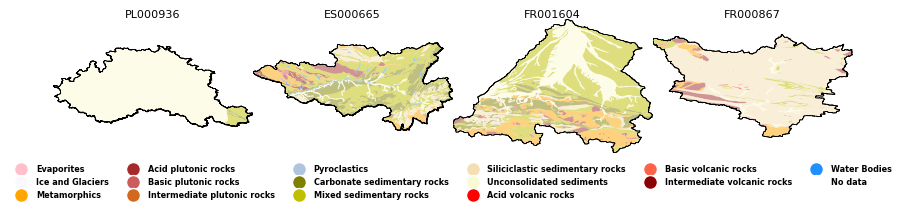

In [247]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define color mappings for legend
color_mapping_glim_legend = {
    'Evaporites': "pink",
    'Ice and Glaciers': "ghostwhite",
    'Metamorphics': "orange",
    'Acid plutonic rocks': "brown",
    'Basic plutonic rocks': "indianred",
    'Intermediate plutonic rocks': "chocolate",
    'Pyroclastics': "lightsteelblue",
    'Carbonate sedimentary rocks': "olive",
    'Mixed sedimentary rocks': "y",
    'Siliciclastic sedimentary rocks': "#F5DEB3",
    'Unconsolidated sediments': "#FAFAD2",
    'Acid volcanic rocks': "red",
    'Basic volcanic rocks': "tomato",
    'Intermediate volcanic rocks': "darkred",
    'Water Bodies': "#1E90FF",
    'No data': "white"
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "ES000665", "FR001604", "FR000867"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2.2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 4
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, j)
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_mapping_glim_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=6, frameon=False, fontsize='small', title='')

# Add catchment labels to the figure, aligning them above each subplot
for i, catchment_id in enumerate(catchment_ids):
    # Position relative to each subplot area
    fig.text(0.125 + i % n_cols * 1 / n_cols, 0.825 - i // n_cols * 1 / n_rows, f'{catchment_id}',
             ha='center', va='center', fontsize=8, fontweight='normal')
    

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_geologies_a.png', dpi=300, bbox_inches='tight')


plt.show()


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

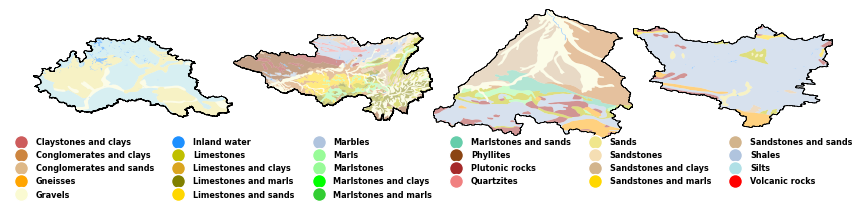

In [243]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Extended color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',             # Same as existing
    'Clays': '#CD5C5C',                              # Similar to Claystones and clays
    'Conglomerates': '#D2B48C',                      # Tan, close to Gravels
    'Conglomerates and clays': '#CD853F',            # Peru, slightly darker to indicate mixture
    'Conglomerates and sands': '#DEB887',            # Burlywood, close to Sands
    'Gneisses': 'orange',                            # Same as existing
    'Gravels': '#FAFAD2',                            # Same as existing
    'Inland water': '#1E90FF',                       # Same as existing
    'Limestones': 'y',                               # Same as existing
    'Limestones and clays': '#DAA520',               # Goldenrod, close to Limestones
    'Limestones and marls': 'olive',                 # Same as existing
    'Limestones and sands': '#FFD700',               # Gold, close to Limestones
    'Marbles': '#B0C4DE',                            # LightSteelBlue, similar to Quartzites but distinct
    'Marls': '#98FB98',                              # Pale Green, distinct but related to marlstones
    'Marlstones': 'palegreen',                       # Same as existing
    'Marlstones and clays': 'lime',                  # Same as existing
    'Marlstones and marls': '#32CD32',               # Same as existing
    'Marlstones and sands': '#66CDAA',               # Medium Aquamarine, slightly related to Marl
    'Phyllites': '#8B4513',                          # SaddleBrown, similar to Plutonic rocks
    'Plutonic rocks': 'brown',                       # Same as existing
    'Quartzites': 'lightcoral',                      # Same as existing
    'Sands': 'khaki',                                # Same as existing
    'Sandstones': '#F5DEB3',                         # Same as existing
    'Sandstones and clays': '#D2B48C',               # Tan, slightly darker as mixture
    'Sandstones and marls': 'gold',                  # Same as existing
    'Sandstones and sands': 'tan',                   # Same as existing
    'Schists': '#778899',                            # LightSlateGray, similar to Shales
    'Shales': 'lightsteelblue',                      # Same as existing
    'Silts': '#B0E0E6',                              # PowderBlue, similar to clays but softer
    'Snow field / ice field': '#F8F8FF',             # GhostWhite, indicating a cold area
    'Volcanic rocks': 'red'                          # Same as existing
}

color_mapping_geology_legend = {
    'Claystones and clays': 'indianred',
    #'Clays': '#CD5C5C',
    #'Conglomerates': '#D2B48C',
    'Conglomerates and clays': '#CD853F',
    'Conglomerates and sands': '#DEB887',
    'Gneisses': 'orange',
    'Gravels': '#FAFAD2',
    'Inland water': '#1E90FF',
    'Limestones': 'y',
    'Limestones and clays': '#DAA520',
    'Limestones and marls': 'olive',
    'Limestones and sands': '#FFD700',
    'Marbles': '#B0C4DE',
    'Marls': '#98FB98',
    'Marlstones': 'palegreen',
    'Marlstones and clays': 'lime',
    'Marlstones and marls': '#32CD32',
    'Marlstones and sands': '#66CDAA',
    'Phyllites': '#8B4513',
    'Plutonic rocks': 'brown',
    'Quartzites': 'lightcoral',
    'Sands': 'khaki',
    'Sandstones': '#F5DEB3',
    'Sandstones and clays': '#D2B48C',
    'Sandstones and marls': 'gold',
    'Sandstones and sands': 'tan',
    #'Schists': '#778899',
    'Shales': 'lightsteelblue',
    'Silts': '#B0E0E6',
    #'Snow field / ice field': '#F8F8FF',
    'Volcanic rocks': 'red'
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "ES000665", "FR001604", "FR000867"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 4
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, IHME_reprojected, color_mapping_geology, j)
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_mapping_geology_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=6, frameon=False, fontsize='small', title='')

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_geologies_b.png', dpi=300, bbox_inches='tight')


plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import box

def clip_geology_by_basins(basin_ids, catchment_boundaries, GLiM_reprojected, color_mapping_glim):
    # Select the geometries for the specified basin IDs
    selected_geometries = catchment_boundaries[catchment_boundaries['basin_id'].isin(basin_ids)]

    # Dissolve the selected geometries into one to create a single combined shape for clipping
    combined_geometry = selected_geometries.unary_union

    # Clip the geology map by the combined basin geometry
    clipped_geology = GLiM_reprojected.clip(combined_geometry)

    # Get unique geology classes within the clipped area
    unique_geology_classes = clipped_geology['class'].unique()

    # Map colors to each unique class
    clipped_geology['color'] = clipped_geology['class'].map(color_mapping_glim)

    return clipped_geology, unique_geology_classes

# Example usage:
# List of basin IDs to clip by
#basin_ids = ["FR001604","PL000936", "FR000867", "FR000373"]  # Add more catchment IDs as needed
basin_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]

# Get clipped geology and unique geology classes
clipped_geology, unique_geology_classes = clip_geology_by_basins(basin_ids, catchment_boundaries, GLiM_reprojected, color_mapping_glim)

# Display the unique geology classes in the clipped area
print("Unique geology classes in the clipped area:", unique_geology_classes)


# Get clipped geology and unique geology classes
clipped_geology, unique_geology_classes = clip_geology_by_basins(basin_ids, catchment_boundaries, IHME_reprojected, color_mapping_geology)

# Display the unique geology classes in the clipped area
print("Unique geology classes in the clipped area:", unique_geology_classes)

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

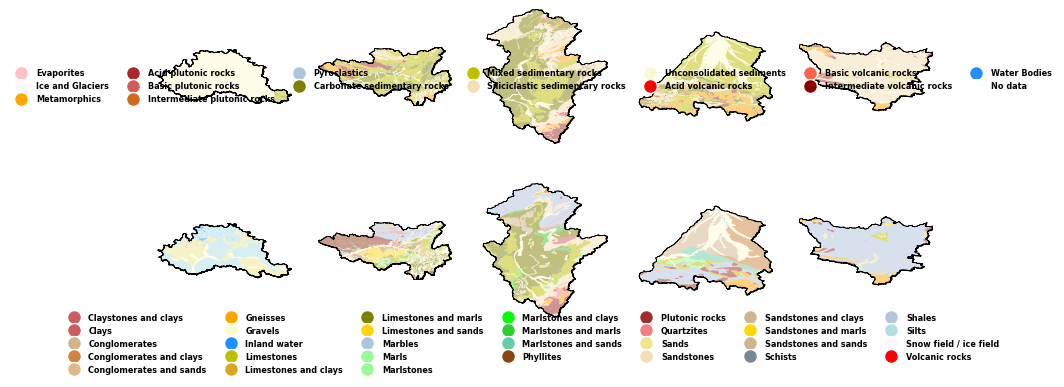

In [235]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
from matplotlib import gridspec

# Sample color mappings for demonstration
color_mapping_glim = {
    'ev': "pink", 'ig': "ghostwhite", 'mt': "orange", 'pa': "brown", 
    'pb': "indianred", 'pi': "chocolate", 'py': "lightsteelblue", 'sc': "olive", 
    'sm': "y", 'ss': "#F5DEB3", 'su': "#FAFAD2", 'va': "red", 'vb': "tomato", 
    'vi': "darkred", 'wb': "#1E90FF", 'nd': "white"
}
color_mapping_geology = {
    'Claystones and clays': 'indianred', 'Clays': '#CD5C5C', 'Conglomerates': '#D2B48C',
    'Conglomerates and clays': '#CD853F', 'Conglomerates and sands': '#DEB887', 'Gneisses': 'orange',
    'Gravels': '#FAFAD2', 'Inland water': '#1E90FF', 'Limestones': 'y', 'Limestones and clays': '#DAA520',
    'Limestones and marls': 'olive', 'Limestones and sands': '#FFD700', 'Marbles': '#B0C4DE',
    'Marls': '#98FB98', 'Marlstones': 'palegreen', 'Marlstones and clays': 'lime',
    'Marlstones and marls': '#32CD32', 'Marlstones and sands': '#66CDAA', 'Phyllites': '#8B4513',
    'Plutonic rocks': 'brown', 'Quartzites': 'lightcoral', 'Sands': 'khaki', 'Sandstones': '#F5DEB3',
    'Sandstones and clays': '#D2B48C', 'Sandstones and marls': 'gold', 'Sandstones and sands': 'tan',
    'Schists': '#778899', 'Shales': 'lightsteelblue', 'Silts': '#B0E0E6', 'Snow field / ice field': '#F8F8FF',
    'Volcanic rocks': 'red'
}

# Define color mappings for legend
color_mapping_glim_legend = {
    'Evaporites': "pink",
    'Ice and Glaciers': "ghostwhite",
    'Metamorphics': "orange",
    'Acid plutonic rocks': "brown",
    'Basic plutonic rocks': "indianred",
    'Intermediate plutonic rocks': "chocolate",
    'Pyroclastics': "lightsteelblue",
    'Carbonate sedimentary rocks': "olive",
    'Mixed sedimentary rocks': "y",
    'Siliciclastic sedimentary rocks': "#F5DEB3",
    'Unconsolidated sediments': "#FAFAD2",
    'Acid volcanic rocks': "red",
    'Basic volcanic rocks': "tomato",
    'Intermediate volcanic rocks': "darkred",
    'Water Bodies': "#1E90FF",
    'No data': "white"
}

# Catchment IDs and layout setup
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
n_cols = 5
n_rows = 1

# Create main figure and GridSpec for layout
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)

# Row 1 for GLiM dissolved plots
gs_glim = gridspec.GridSpecFromSubplotSpec(n_rows, n_cols, subplot_spec=gs[0])
for i, catchment_id in enumerate(catchment_ids):
    ax = fig.add_subplot(gs_glim[i])
    plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, i)


# Add GLiM legend below first row
legend_elements_glim = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                        for label, color in color_mapping_glim_legend.items()]
fig.legend(handles=legend_elements_glim, loc='upper center', bbox_to_anchor=(0.5, 0.75), ncol=7, frameon=False, fontsize='small')

# Row 2 for geology plots
gs_geology = gridspec.GridSpecFromSubplotSpec(n_rows, n_cols, subplot_spec=gs[1])
for i, catchment_id in enumerate(catchment_ids):
    ax = fig.add_subplot(gs_geology[i])
    plot_catchment(ax, catchment_id, catchment_boundaries, IHME_reprojected, color_mapping_geology, i)


# Add Geology legend below second row
legend_elements_geology = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                           for label, color in color_mapping_geology.items()]
fig.legend(handles=legend_elements_geology, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=7, frameon=False, fontsize='small')

plt.tight_layout()
plt.show()


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

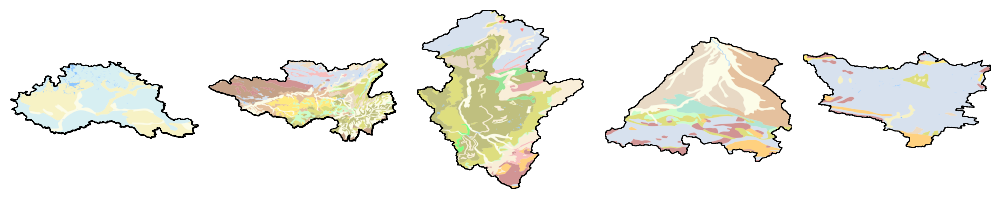

In [221]:
# List of catchments to plot

#catchment_ids = ["FR001604","PL000936", "FR000867", "FR000373"]  # Add more catchment IDs as needed
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]

# Extended color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',             # Same as existing
    'Clays': '#CD5C5C',                              # Similar to Claystones and clays
    'Conglomerates': '#D2B48C',                      # Tan, close to Gravels
    'Conglomerates and clays': '#CD853F',            # Peru, slightly darker to indicate mixture
    'Conglomerates and sands': '#DEB887',            # Burlywood, close to Sands
    'Gneisses': 'orange',                            # Same as existing
    'Gravels': '#FAFAD2',                            # Same as existing
    'Inland water': '#1E90FF',                       # Same as existing
    'Limestones': 'y',                               # Same as existing
    'Limestones and clays': '#DAA520',               # Goldenrod, close to Limestones
    'Limestones and marls': 'olive',                 # Same as existing
    'Limestones and sands': '#FFD700',               # Gold, close to Limestones
    'Marbles': '#B0C4DE',                            # LightSteelBlue, similar to Quartzites but distinct
    'Marls': '#98FB98',                              # Pale Green, distinct but related to marlstones
    'Marlstones': 'palegreen',                       # Same as existing
    'Marlstones and clays': 'lime',                  # Same as existing
    'Marlstones and marls': '#32CD32',               # Same as existing
    'Marlstones and sands': '#66CDAA',               # Medium Aquamarine, slightly related to Marl
    'Phyllites': '#8B4513',                          # SaddleBrown, similar to Plutonic rocks
    'Plutonic rocks': 'brown',                       # Same as existing
    'Quartzites': 'lightcoral',                      # Same as existing
    'Sands': 'khaki',                                # Same as existing
    'Sandstones': '#F5DEB3',                         # Same as existing
    'Sandstones and clays': '#D2B48C',               # Tan, slightly darker as mixture
    'Sandstones and marls': 'gold',                  # Same as existing
    'Sandstones and sands': 'tan',                   # Same as existing
    'Schists': '#778899',                            # LightSlateGray, similar to Shales
    'Shales': 'lightsteelblue',                      # Same as existing
    'Silts': '#B0E0E6',                              # PowderBlue, similar to clays but softer
    'Snow field / ice field': '#F8F8FF',             # GhostWhite, indicating a cold area
    'Volcanic rocks': 'red'                          # Same as existing
}

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 6
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted

# Prepare the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))

# Flatten axes array to easily iterate over it
axes = axes.flatten()
j = 0
# Plot each catchment in a subplot
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, IHME_reprojected, color_mapping_geology, j)
    j = j + 1

# Remove empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.tight_layout()
plt.show()

In [223]:
import geopandas as gpd
from shapely.geometry import box

def clip_geology_by_basins(basin_ids, catchment_boundaries, GLiM_reprojected, color_mapping_glim):
    # Select the geometries for the specified basin IDs
    selected_geometries = catchment_boundaries[catchment_boundaries['basin_id'].isin(basin_ids)]

    # Dissolve the selected geometries into one to create a single combined shape for clipping
    combined_geometry = selected_geometries.unary_union

    # Clip the geology map by the combined basin geometry
    clipped_geology = GLiM_reprojected.clip(combined_geometry)

    # Get unique geology classes within the clipped area
    unique_geology_classes = clipped_geology['class'].unique()

    # Map colors to each unique class
    clipped_geology['color'] = clipped_geology['class'].map(color_mapping_glim)

    return clipped_geology, unique_geology_classes

# Example usage:
# List of basin IDs to clip by
basin_ids = ["FR001604","PL000936", "FR000867", "FR000373"]  # Add more catchment IDs as needed
basin_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]

# Get clipped geology and unique geology classes
clipped_geology, unique_geology_classes = clip_geology_by_basins(basin_ids, catchment_boundaries, GLiM_reprojected, color_mapping_glim)

# Display the unique geology classes in the clipped area
print("Unique geology classes in the clipped area:", unique_geology_classes)




Unique geology classes in the clipped area: ['wb' 'vb' 'ss' 'pa' 'vi' 'mt' 'pb' 'sm' 'sc' 'su' 'va' 'pi']


In [224]:
# Get clipped geology and unique geology classes
clipped_geology, unique_geology_classes = clip_geology_by_basins(basin_ids, catchment_boundaries, IHME_reprojected, color_mapping_geology)

# Display the unique geology classes in the clipped area
print("Unique geology classes in the clipped area:", unique_geology_classes)


Unique geology classes in the clipped area: ['Marlstones and marls' 'Marlstones and clays' 'Gravels'
 'Sandstones and sands' 'Sandstones and marls' 'Conglomerates and clays'
 'Volcanic rocks' 'Conglomerates and sands' 'Limestones and sands'
 'Marlstones and sands' 'Marls' 'Inland water' 'Limestones and marls'
 'Sands' 'Plutonic rocks' 'Phyllites' 'Marbles' 'Shales' 'Marlstones'
 'Limestones' 'Sandstones and clays' 'Gneisses' 'Quartzites' 'Sandstones'
 'Silts' 'Claystones and clays']


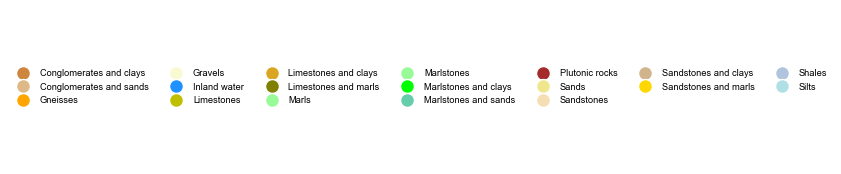

In [170]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

color_mapping_geology_legend = {
    'Claystones and clays': 'indianred',
    #'Clays': '#CD5C5C',
    #'Conglomerates': '#D2B48C',
    'Conglomerates and clays': '#CD853F',
    'Conglomerates and sands': '#DEB887',
    'Gneisses': 'orange',
    'Gravels': '#FAFAD2',
    'Inland water': '#1E90FF',
    'Limestones': 'y',
    'Limestones and clays': '#DAA520',
    'Limestones and marls': 'olive',
    'Limestones and sands': '#FFD700',
    'Marbles': '#B0C4DE',
    'Marls': '#98FB98',
    'Marlstones': 'palegreen',
    'Marlstones and clays': 'lime',
    'Marlstones and marls': '#32CD32',
    'Marlstones and sands': '#66CDAA',
    'Phyllites': '#8B4513',
    'Plutonic rocks': 'brown',
    'Quartzites': 'lightcoral',
    'Sands': 'khaki',
    'Sandstones': '#F5DEB3',
    'Sandstones and clays': '#D2B48C',
    'Sandstones and marls': 'gold',
    'Sandstones and sands': 'tan',
    #'Schists': '#778899',
    'Shales': 'lightsteelblue',
    'Silts': '#B0E0E6',
    #'Snow field / ice field': '#F8F8FF',
    'Volcanic rocks': 'red'
}

def plot_legend(color_mapping, title, columns=2):
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.axis('off')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
        for label, color in color_mapping.items()
    ]

    ax.legend(
        handles=legend_elements,
        title=title,
        loc='center',
        ncol=columns,
        frameon=False,
        fontsize='small',
        title_fontsize='medium'
    )
    plt.show()

# Plot geology median dissolved legend
plot_legend(color_mapping_geology, title='', columns=7)

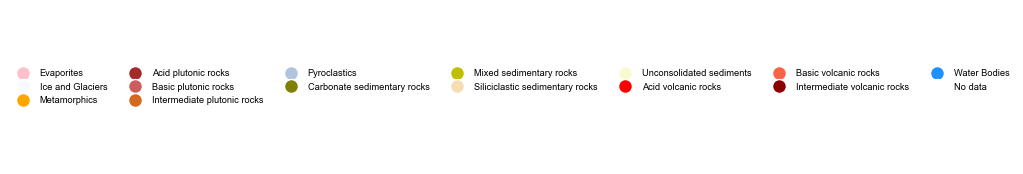

In [176]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the first color mapping for GLiM_dissolved just for the legend (full names)
color_mapping_glim = {
    'Evaporites': "pink",  # Evaporites
    'Ice and Glaciers': "ghostwhite",  # Ice and Glaciers
    'Metamorphics': "orange",  # Metamorphics
    'Acid plutonic rocks': "brown",  # Acid plutonic rocks
    'Basic plutonic rocks': "indianred",  # Basic plutonic rocks
    'Intermediate plutonic rocks': "chocolate",  # Intermediate plutonic rocks
    'Pyroclastics': "lightsteelblue",  # Pyroclastics
    'Carbonate sedimentary rocks': "olive",  # Carbonate sedimentary rocks
    'Mixed sedimentary rocks': "y",  # Mixed sedimentary rocks
    'Siliciclastic sedimentary rocks': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'Unconsolidated sediments': "#FAFAD2",  # Unconsolidated sediments
    'Acid volcanic rocks': "red",  # Acid volcanic rocks
    'Basic volcanic rocks': "tomato",  # Basic volcanic rocks
    'Intermediate volcanic rocks': "darkred",  # Intermediate volcanic rocks
    'Water Bodies': "#1E90FF",  # Water Bodies
    'No data': "white"   # Precambrian rocks
}
def plot_legend(color_mapping, title, columns=2):
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.axis('off')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
        for label, color in color_mapping.items()
    ]

    ax.legend(
        handles=legend_elements,
        title=title,
        loc='center',
        ncol=columns,
        frameon=False,
        fontsize='small',
        title_fontsize='medium'
    )
    plt.show()

# Plot GLiM dissolved legend
plot_legend(color_mapping_glim, title='', columns=7)

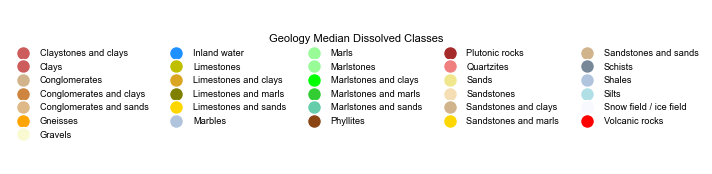

In [164]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

color_mapping_geology = {
    #'Claystones and clays': 'indianred',
    #'Clays': '#CD5C5C',
    #'Conglomerates': '#D2B48C',
    #'Conglomerates and clays': '#CD853F',
    #'Conglomerates and sands': '#DEB887',
    #'Gneisses': 'orange',
    'Gravels': '#FAFAD2',
    #'Inland water': '#1E90FF',
    #'Limestones': 'y',
    #'Limestones and clays': '#DAA520',
    #'Limestones and marls': 'olive',
    #'Limestones and sands': '#FFD700',
    #'Marbles': '#B0C4DE',
    #'Marls': '#98FB98',
    #'Marlstones': 'palegreen',
    #'Marlstones and clays': 'lime',
    #'Marlstones and marls': '#32CD32',
    #'Marlstones and sands': '#66CDAA',
    #'Phyllites': '#8B4513',
    #'Plutonic rocks': 'brown',
    #'Quartzites': 'lightcoral',
    #'Sands': 'khaki',
    #'Sandstones': '#F5DEB3',
    'Sandstones and clays': '#D2B48C',
    #'Sandstones and marls': 'gold',
    #'Sandstones and sands': 'tan',
    #'Schists': '#778899',
    #'Shales': 'lightsteelblue',
    #'Silts': '#B0E0E6',
    #'Snow field / ice field': '#F8F8FF',
    #'Volcanic rocks': 'red'
}

def plot_legend(color_mapping, title, columns=2):
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.axis('off')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
        for label, color in color_mapping.items()
    ]

    ax.legend(
        handles=legend_elements,
        title=title,
        loc='center',
        ncol=columns,
        frameon=False,
        fontsize='small',
        title_fontsize='medium'
    )
    plt.show()

# Plot geology median dissolved legend
plot_legend(color_mapping_geology, title='Geology Median Dissolved Classes', columns=5)



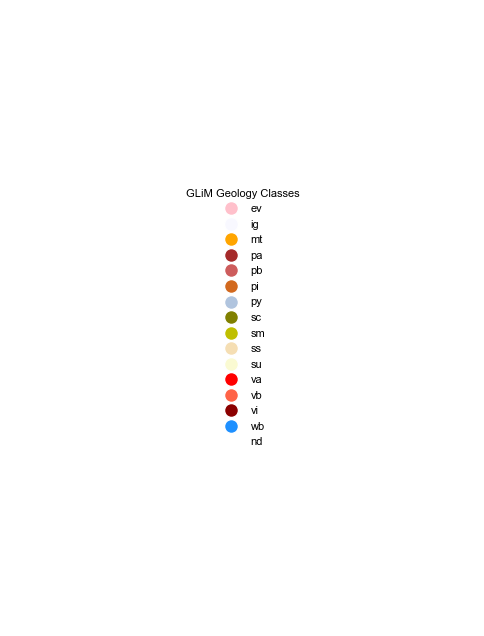

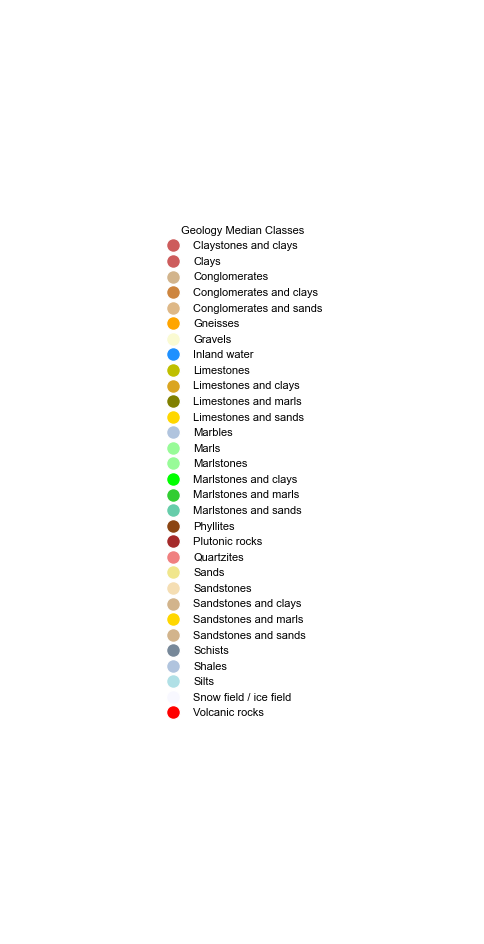

In [154]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the two color mappings
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

color_mapping_geology = {
    'Claystones and clays': 'indianred',
    'Clays': '#CD5C5C',
    'Conglomerates': '#D2B48C',
    'Conglomerates and clays': '#CD853F',
    'Conglomerates and sands': '#DEB887',
    'Gneisses': 'orange',
    'Gravels': '#FAFAD2',
    'Inland water': '#1E90FF',
    'Limestones': 'y',
    'Limestones and clays': '#DAA520',
    'Limestones and marls': 'olive',
    'Limestones and sands': '#FFD700',
    'Marbles': '#B0C4DE',
    'Marls': '#98FB98',
    'Marlstones': 'palegreen',
    'Marlstones and clays': 'lime',
    'Marlstones and marls': '#32CD32',
    'Marlstones and sands': '#66CDAA',
    'Phyllites': '#8B4513',
    'Plutonic rocks': 'brown',
    'Quartzites': 'lightcoral',
    'Sands': 'khaki',
    'Sandstones': '#F5DEB3',
    'Sandstones and clays': '#D2B48C',
    'Sandstones and marls': 'gold',
    'Sandstones and sands': 'tan',
    'Schists': '#778899',
    'Shales': 'lightsteelblue',
    'Silts': '#B0E0E6',
    'Snow field / ice field': '#F8F8FF',
    'Volcanic rocks': 'red'
}

# Plot legend for color_mapping_glim
fig1, ax1 = plt.subplots(figsize=(6, 8))
glim_legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=key) for key, color in color_mapping_glim.items()]
ax1.legend(handles=glim_legend_elements, title='GLiM Geology Classes', loc='center', frameon=False)
ax1.axis('off')

# Plot legend for color_mapping_geology
fig2, ax2 = plt.subplots(figsize=(6, 12))
geology_legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=key) for key, color in color_mapping_geology.items()]
ax2.legend(handles=geology_legend_elements, title='Geology Median Classes', loc='center', frameon=False)
ax2.axis('off')

plt.show()


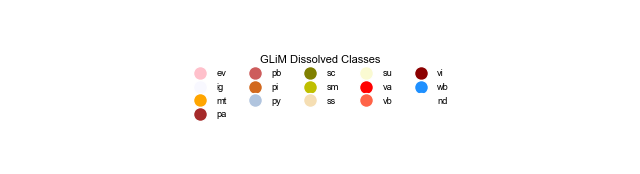

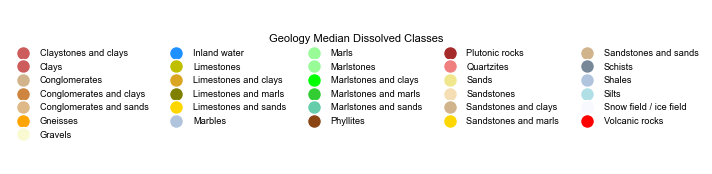

In [157]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the color mappings
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

color_mapping_geology = {
    'Claystones and clays': 'indianred',
    'Clays': '#CD5C5C',
    'Conglomerates': '#D2B48C',
    'Conglomerates and clays': '#CD853F',
    'Conglomerates and sands': '#DEB887',
    'Gneisses': 'orange',
    'Gravels': '#FAFAD2',
    'Inland water': '#1E90FF',
    'Limestones': 'y',
    'Limestones and clays': '#DAA520',
    'Limestones and marls': 'olive',
    'Limestones and sands': '#FFD700',
    'Marbles': '#B0C4DE',
    'Marls': '#98FB98',
    'Marlstones': 'palegreen',
    'Marlstones and clays': 'lime',
    'Marlstones and marls': '#32CD32',
    'Marlstones and sands': '#66CDAA',
    'Phyllites': '#8B4513',
    'Plutonic rocks': 'brown',
    'Quartzites': 'lightcoral',
    'Sands': 'khaki',
    'Sandstones': '#F5DEB3',
    'Sandstones and clays': '#D2B48C',
    'Sandstones and marls': 'gold',
    'Sandstones and sands': 'tan',
    'Schists': '#778899',
    'Shales': 'lightsteelblue',
    'Silts': '#B0E0E6',
    'Snow field / ice field': '#F8F8FF',
    'Volcanic rocks': 'red'
}

def plot_legend(color_mapping, title, columns=2):
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.axis('off')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
        for label, color in color_mapping.items()
    ]

    ax.legend(
        handles=legend_elements,
        title=title,
        loc='center',
        ncol=columns,
        frameon=False,
        fontsize='small',
        title_fontsize='medium'
    )
    plt.show()

# Plot GLiM dissolved legend
plot_legend(color_mapping_glim, title='GLiM Dissolved Classes', columns=3)

# Plot geology median dissolved legend
plot_legend(color_mapping_geology, title='Geology Median Dissolved Classes', columns=4)


<Axes: >

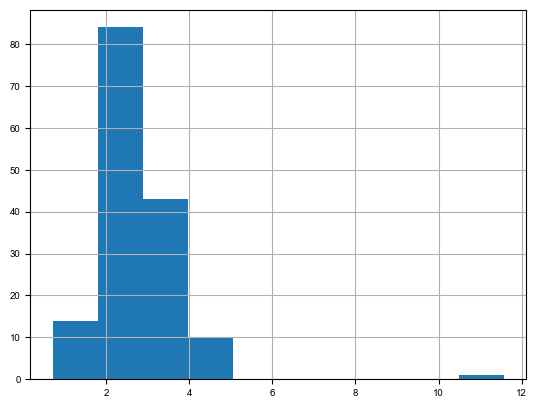

In [ ]:
network_estreams_filtered.slope_sawicz.hist()